In [46]:
import pickle
import torch
import sbi
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from IPython.display import HTML, Image
import os
import warnings
from scipy.stats import mode
import random

In [2]:
def _genNumpyArrays(path):
    '''
    Enter the path to a sbi output folder and
    returns a Numpy Array of len(n_samples) including
        posterior_samples : (slic = 0, 1) parameter estimates at observation
        RMSE_NSE_KGE_param : (slic = 2, 3, 4) fit (RMSE, NSE, KGE) of each sample parameter to true parameters
        log_probability : (slic = 5) the log probability of each parameter sample
    '''
    # posterior_samples = parameter estimates at observation
    # samples_fit_params = fit (RMSE, NSE, KGE) of each sample parameter to true parameters
    # all are tensor arrays

    obj_list = ['posterior_samples.pkl', 'RMSE_NSE_KGE_params.pkl', 'log_probability.pkl']

    for i in range(len(obj_list)):
        # load object
        obj = obj_list[i]
        path_obj = path+obj
        with open(path_obj, "rb") as handle:
            out = pickle.load(handle) 

        # create a big tensor array
        if i == 0: 
            out_arr = out
        else:
            out_arr = torch.cat((out_arr, out), 1)
        del out, path_obj
        
    return out_arr.data.numpy()

def _readArray(home_path, scenario_list, slic=None):
    '''
    Reads in path and list of DELFI sbi results within a scenario (that you want to compare)
    To prepare for Plotting in a Box Plot
    Returns item_list (which matches the dimension of scenario list)
    slic (optionally) for slicing data so that you only get what you want (see the dimensions)
    '''
    item_list = []
    for item in scenario_list:
        path = home_path + item
        arr_out = _genNumpyArrays(path)
        if slic is not None:
            arr_out = arr_out[:,slic]
        item_list.append(arr_out)
    return item_list

def realParams(path,key):
    with open(path+'val.txt') as f:
        lines = f.readlines()

    for line in lines:
        if line.find(key) != -1:
            vals = line[line.find('[')+1:-2]
            vals = [float(idx) for idx in vals.split(",")]
            break
    return vals

def appendArray(home_path, scenario_list, slic):
    plt_list = _readArray(home_path, scenario_list, slic)
    for i in range(len(plt_list)):
        out = np.expand_dims(plt_list[i], 1)
        out = np.append(out, np.expand_dims(np.ones(len(out))*i, 1), axis = 1)
        if i == 0:
            out_arr = out
        else:
            out_arr = np.append(out_arr, out, axis=0)
#         print(out_arr.shape)
#         out_
        del out
    return out_arr
    


In [3]:
def makeScenarioBox(plt_list, slic, scen_code, trueval=None, save=False, save_path=None):
    '''
    Make box plots
    plt_list = the data to be plotted (must be a list)
    slic = the slicer used from the arr_out data in function _readArray. This corresponds to definitions
        in _getNumpyArrays
    scen_code = what ever you want to call in the box plot
    trueval = None
    SOURCE: https://matplotlib.org/stable/gallery/statistics/boxplot_demo.html
    '''

    data = plt_list

    fig, ax1 = plt.subplots(figsize=(20, 12))
    fig.canvas.manager.set_window_title('A Boxplot Example')
    fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

    bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+')

    # Add a horizontal grid to the plot, but make it very light in color
    # so we can use it for reading data values but not be distracting
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)

    ax1.set(
        axisbelow=True,  # Hide the grid behind plot objects
        title=f'Comparison of slic {slic} Across Several Iterations of {scen_code}',
        xlabel='Distribution',
        ylabel='Value',
    )

    # Now fill the boxes with desired colors
    box_colors = ['darkkhaki', 'royalblue']
    num_boxes = len(data)
    medians = np.empty(num_boxes)
    for i in range(num_boxes):
        box = bp['boxes'][i]
        box_x = []
        box_y = []
        for j in range(5):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        # Alternate between Dark Khaki and Royal Blue
        ax1.add_patch(Polygon(box_coords, facecolor=box_colors[i % 2]))
        # Now draw the median lines back over what we just filled in
        med = bp['medians'][i]
        median_x = []
        median_y = []
        for j in range(2):
            median_x.append(med.get_xdata()[j])
            median_y.append(med.get_ydata()[j])
            ax1.plot(median_x, median_y, 'k')
        medians[i] = median_y[0]
        # Finally, overplot the sample averages, with horizontal alignment
        # in the center of each box
#         print(np.average(med.get_xdata()))
        ax1.plot(np.average(med.get_xdata()), np.average(data[i]),
                 color='w', marker='*', markeredgecolor='k')
        
        # overplot the 'true' parameter value (if trueval exists)
        if type(trueval) == float:
            ## edit
            ax1.plot(np.average(med.get_xdata()), trueval, color='green', marker = 'o')

    # Set the axes ranges and axes labels
    ax1.set_xlim(0.5, num_boxes + 0.5)
    if slic == 2: 
        top = 1
        bottom = 0.0000001
        ax1.set_ylim(bottom, top)
    else:
        ax1.set_yscale('log')
#     ax1.set_xticklabels(scenario_list,
#                         rotation=45, fontsize=8)

    # Due to the Y-axis scale being different across samples, it can be
    # hard to compare differences in medians across the samples. Add upper
    # X-axis tick labels with the sample medians to aid in comparison
    # (just use two decimal places of precision)
    pos = np.arange(num_boxes) + 1
    upper_labels = [str(round(s, 2)) for s in medians]
    weights = ['bold', 'semibold']
    for tick, label in zip(range(num_boxes), ax1.get_xticklabels()):
        k = tick % 2
        ax1.text(pos[tick], .95, upper_labels[tick],
                 transform=ax1.get_xaxis_transform(),
                 horizontalalignment='center', size=12,
                 weight=weights[k], color=box_colors[k])

    if save:
        plt.savefig(f'{save_path}.png')
#         plt.savefig(f'{save_path}.eps', format='eps')
    plt.show()
    
    return None

In [4]:
def dim_2_scatter(arr_x, plot_arr, slic_x, slic_y, scen_code, trueval=False, save=False, save_path=None):
    '''
    2-D scatter
    '''
    # 2D plot 
    fig, ax2 = plt.subplots(figsize=(12, 12))
    for i in np.unique(arr_x[:,1]):
        idx = int(i)
        filtr = np.where(arr_x[:,1] == idx)
        ax2.scatter(arr_x[filtr,0], plot_arr[filtr,0], alpha=0.1, label=f'sbi simulation {idx + 1}')
    if trueval is not False:
        ax2.scatter(arr_x.max(), trueval, alpha=1, c='black', label='true value')
    ax2.set_title(f'{slic_x} v {slic_y} across several iterations - {scen_code}')
    ax2.set_xlabel(f'{slic_x}')
    ax2.set_ylabel(f'{slic_y}')
    ax2.set_ylim(0, 1)
#     ax2.set_xlim(-6, 6)
    # ax2.set_xscale('log')
#     ax2.set_yscale('log')
    plt.legend()
    if save:
        plt.savefig(f'{save_path}.png')
#         plt.savefig(f'{save_path}.eps', format='eps')
    plt.show()
    
    return None

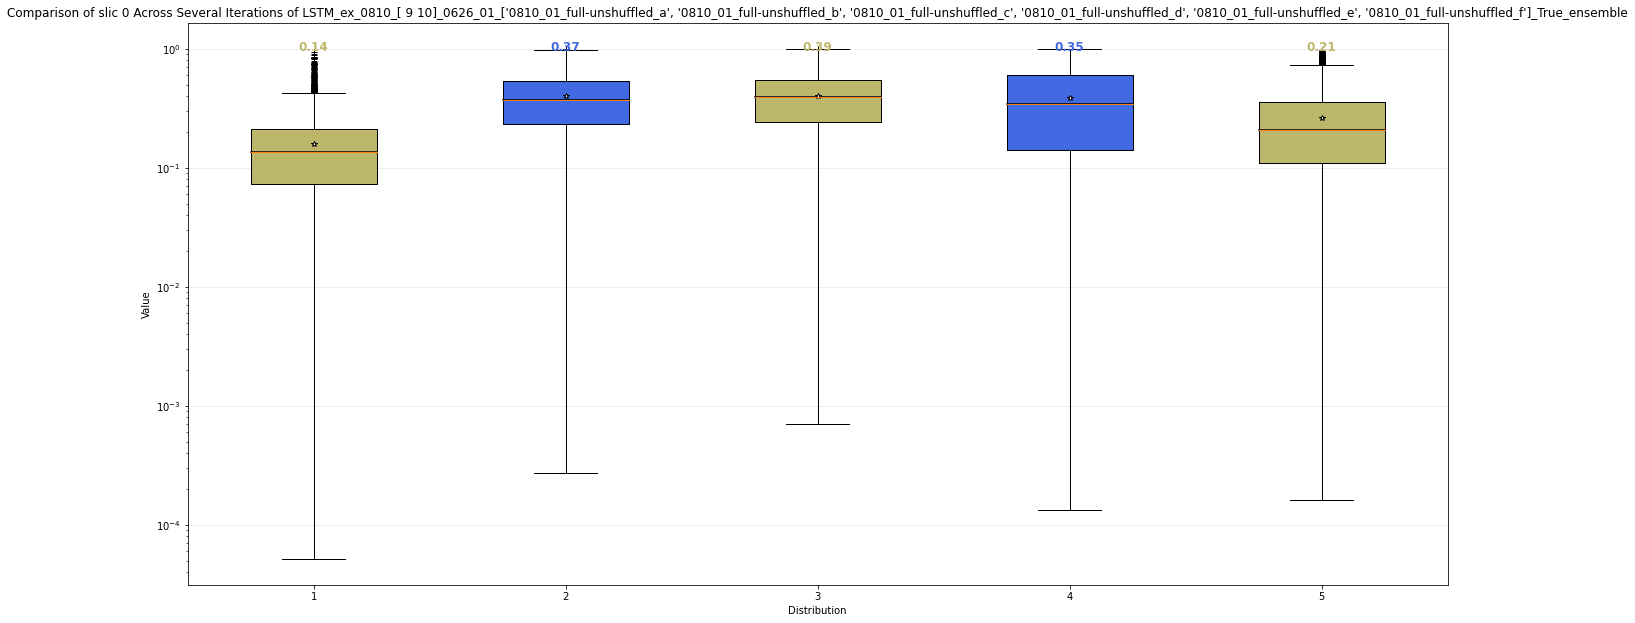

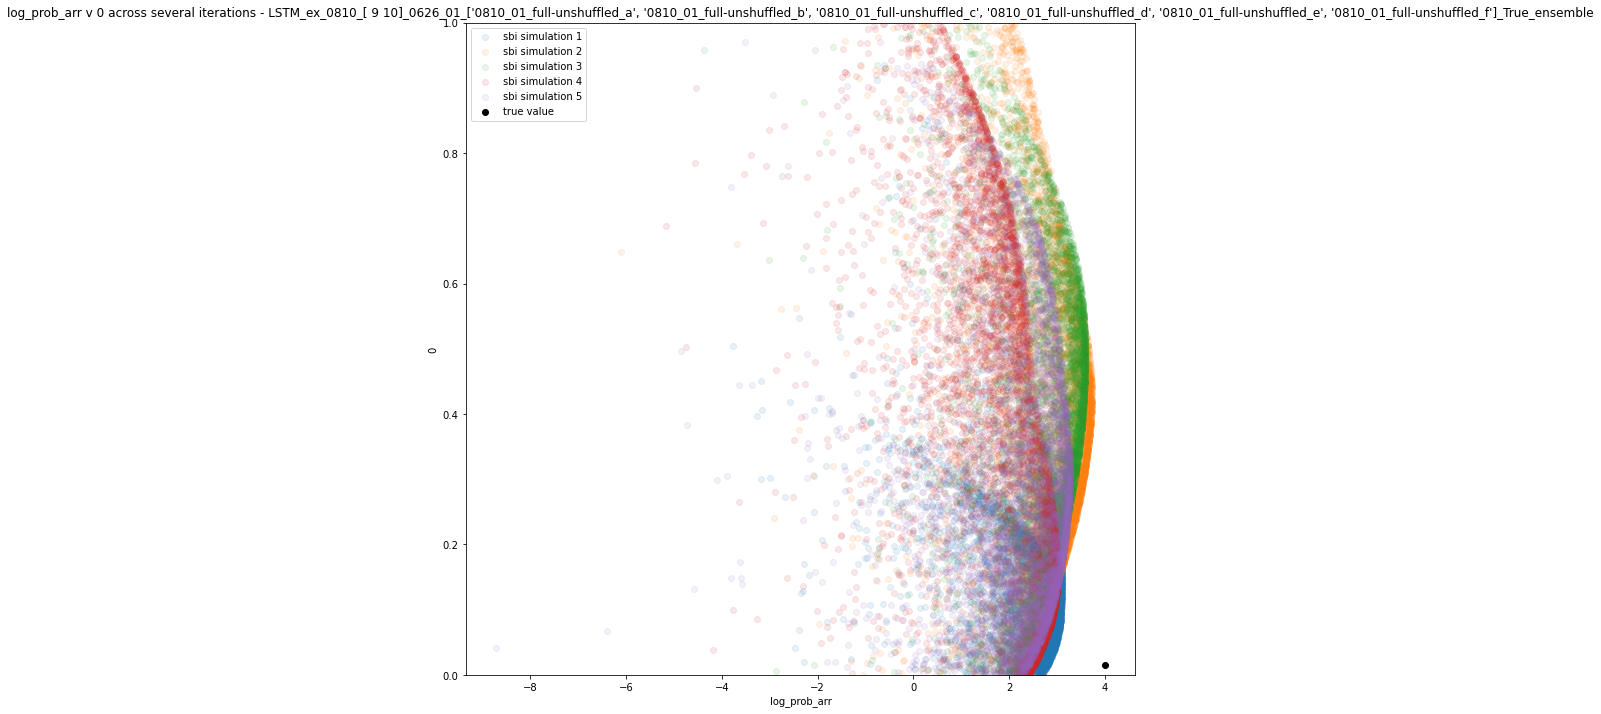

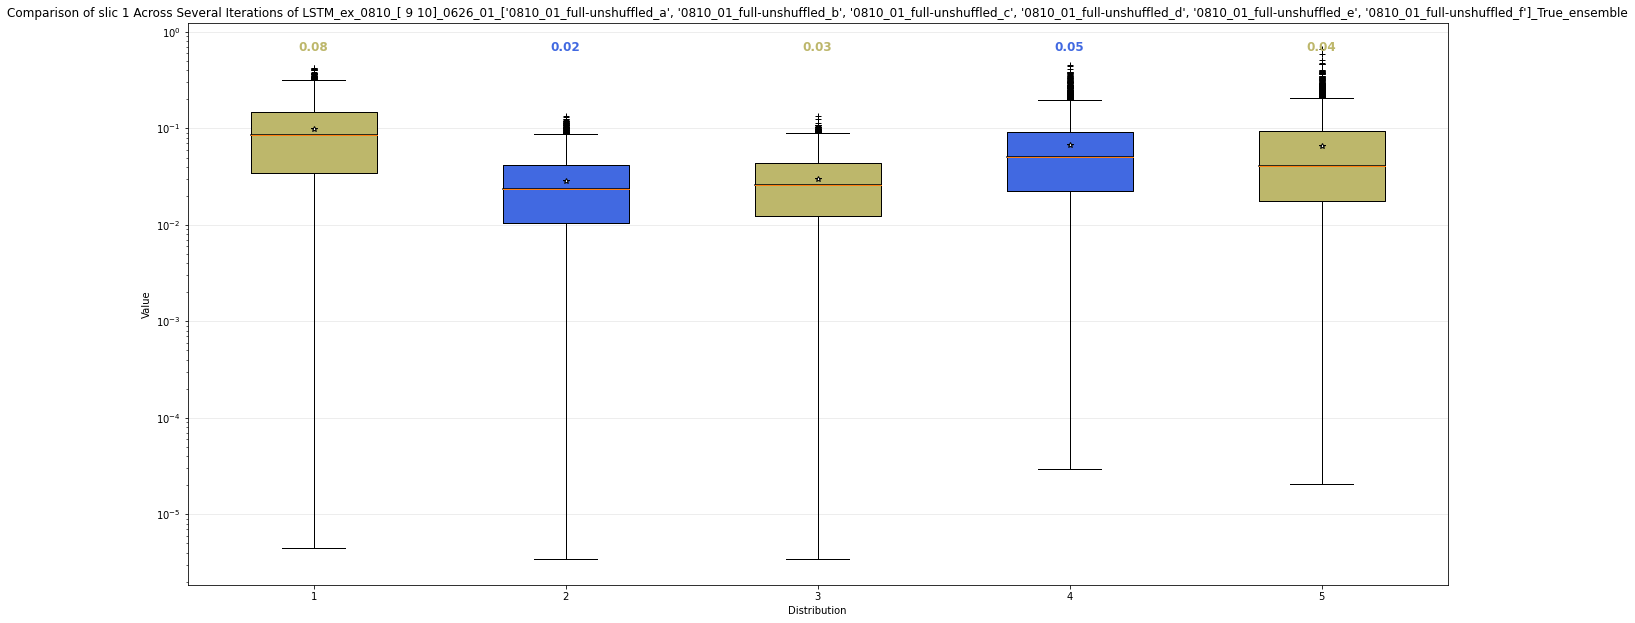

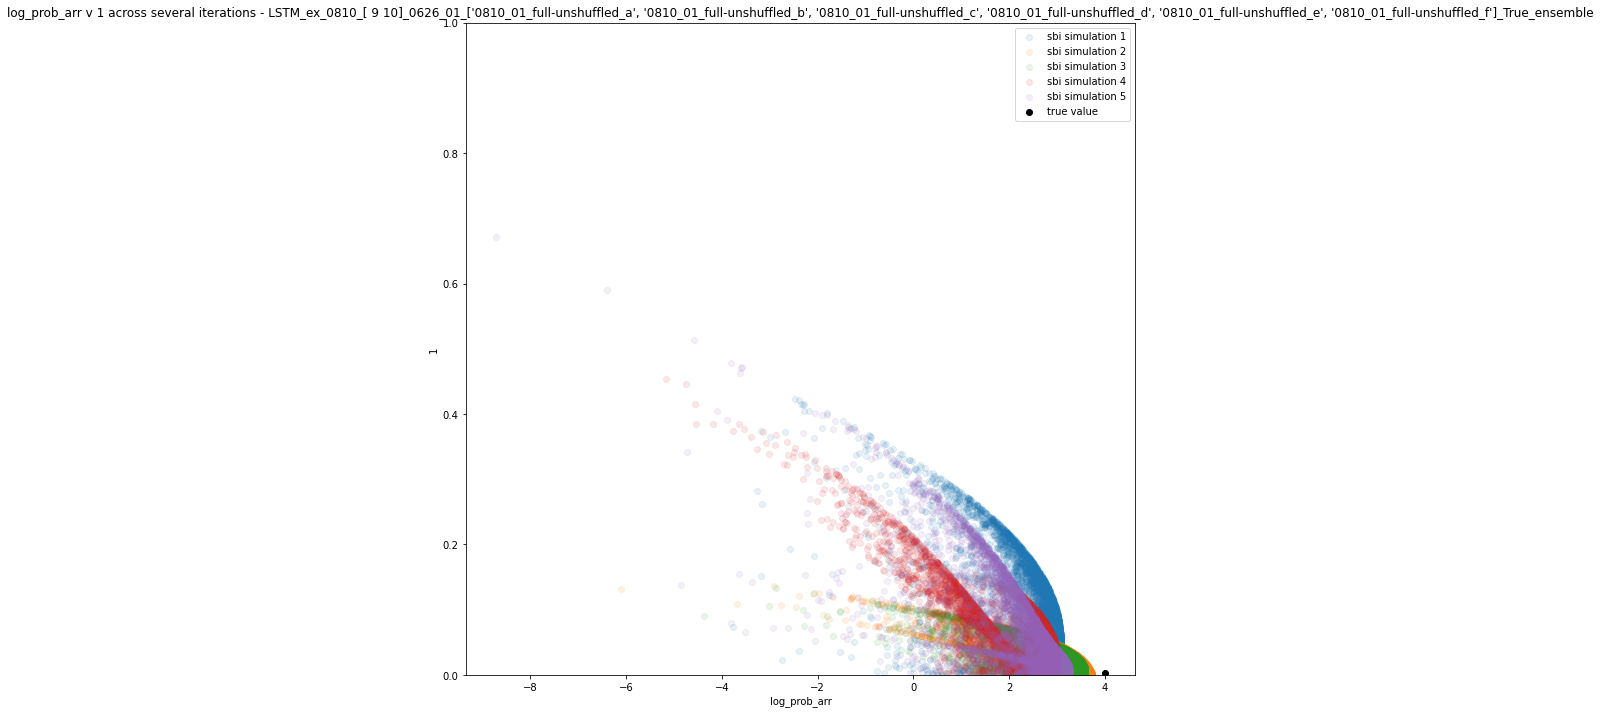

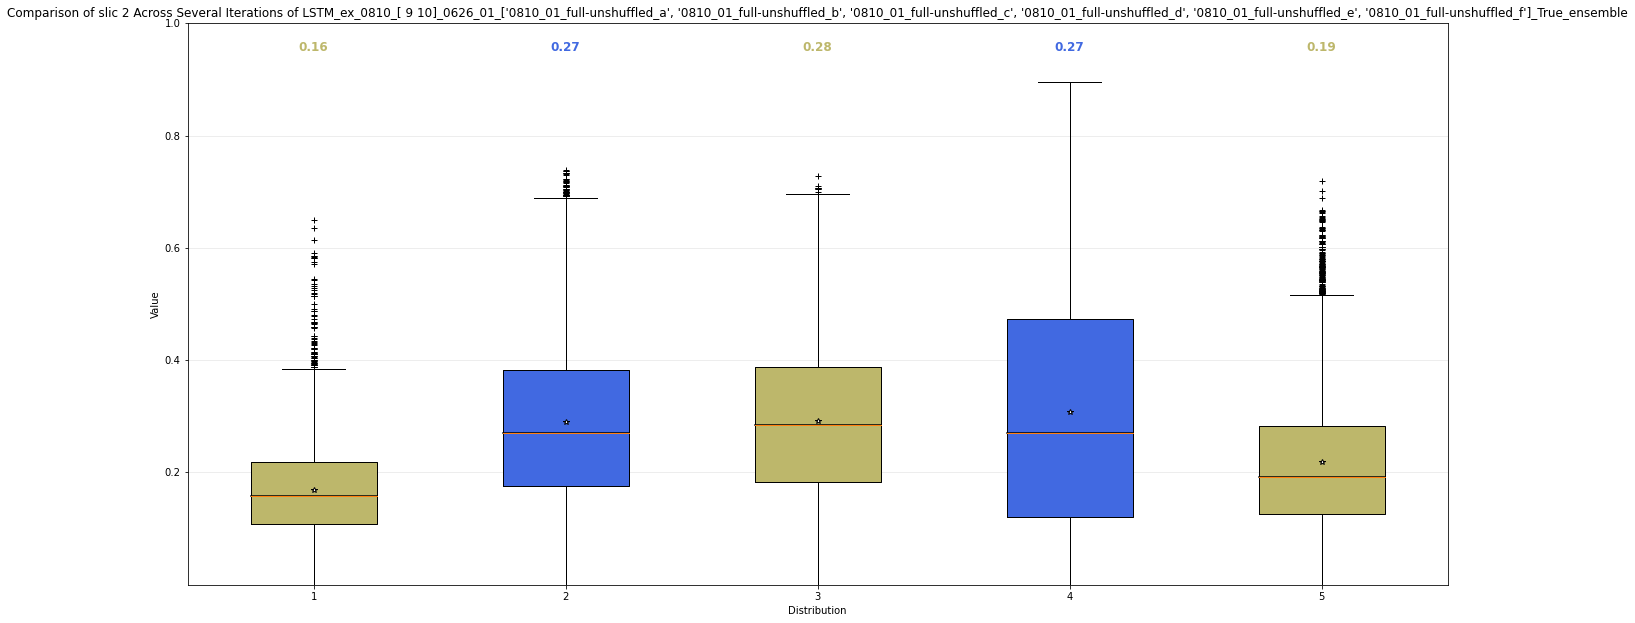

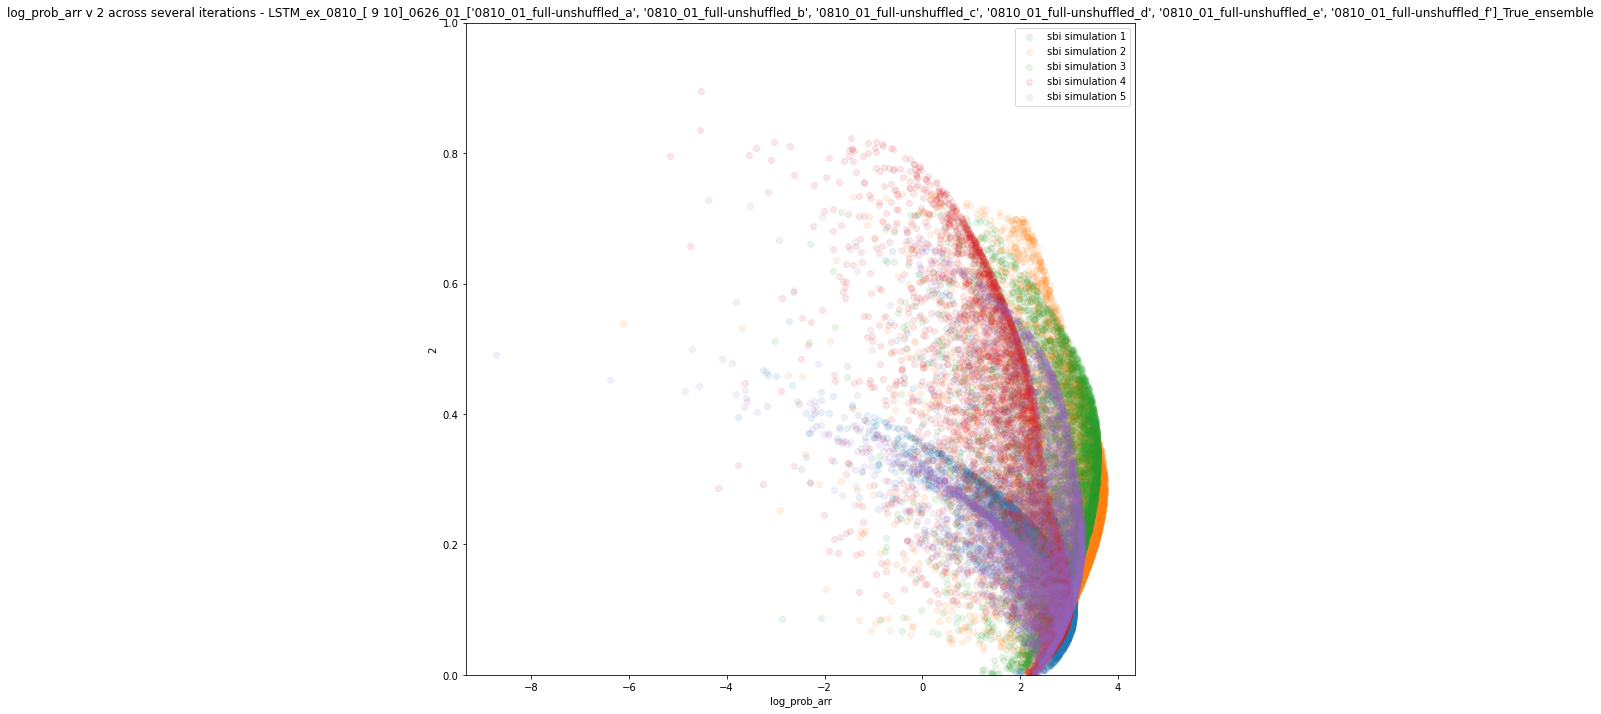

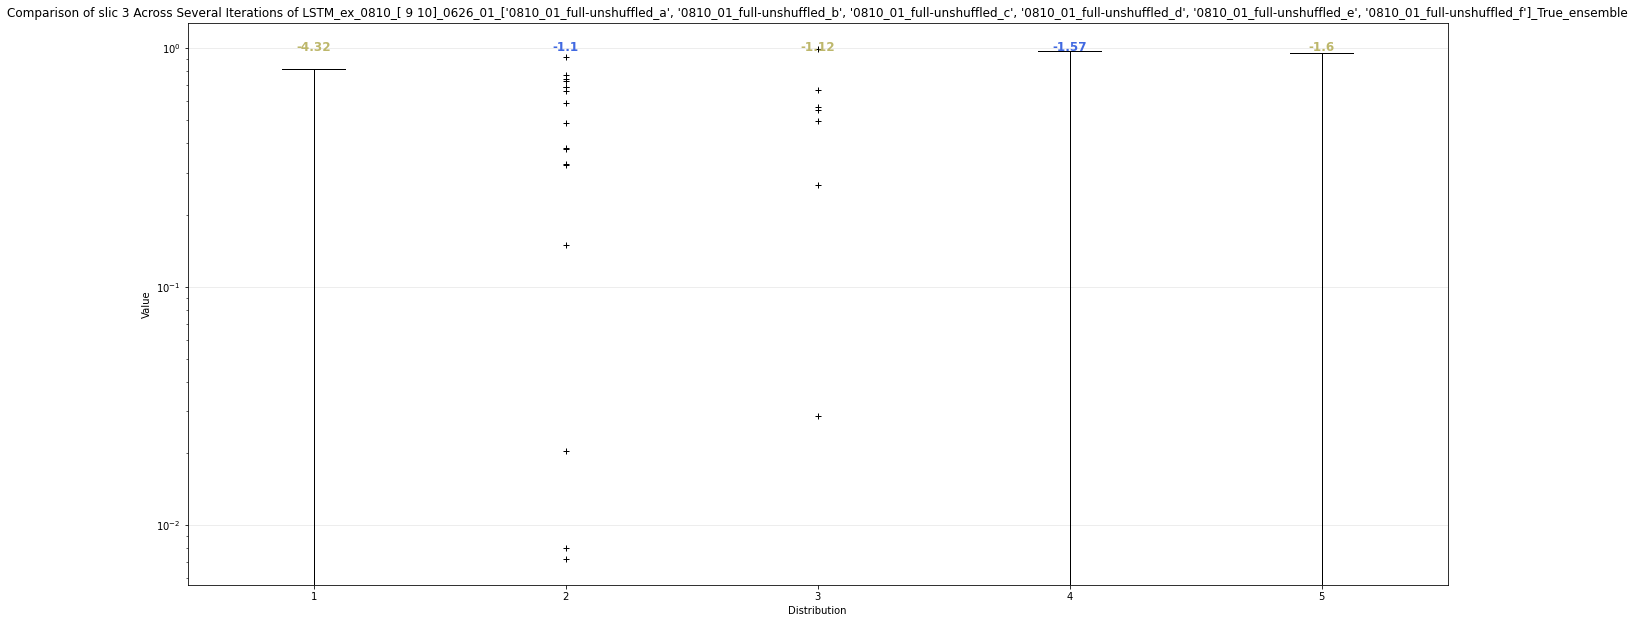

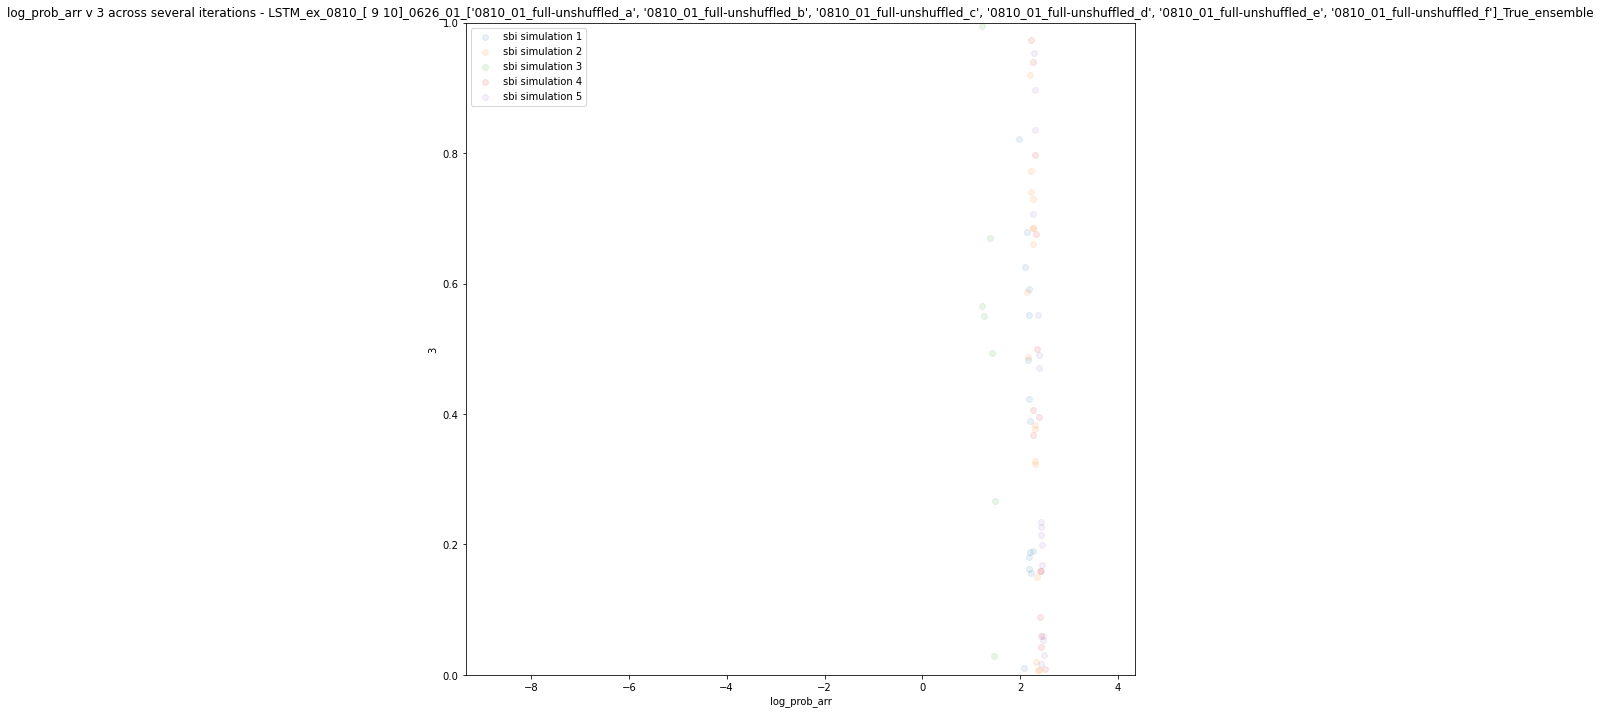

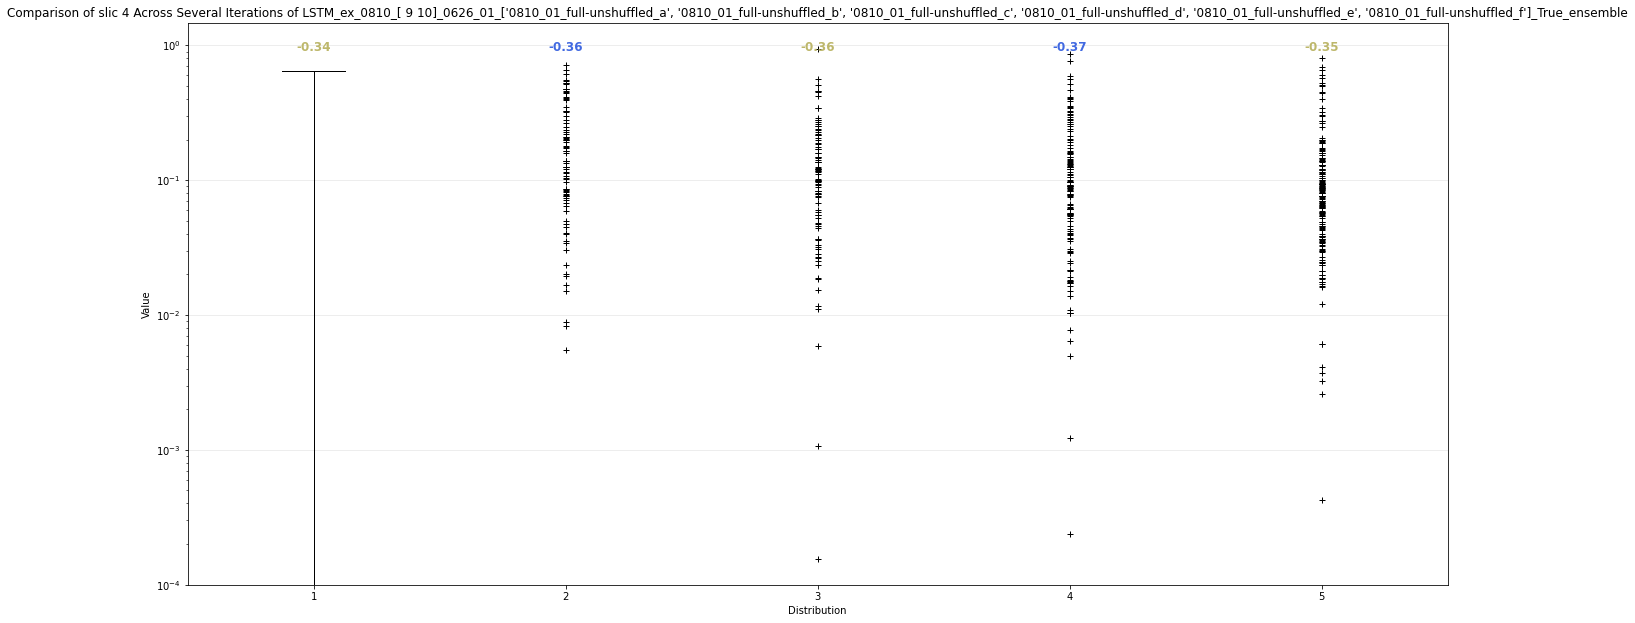

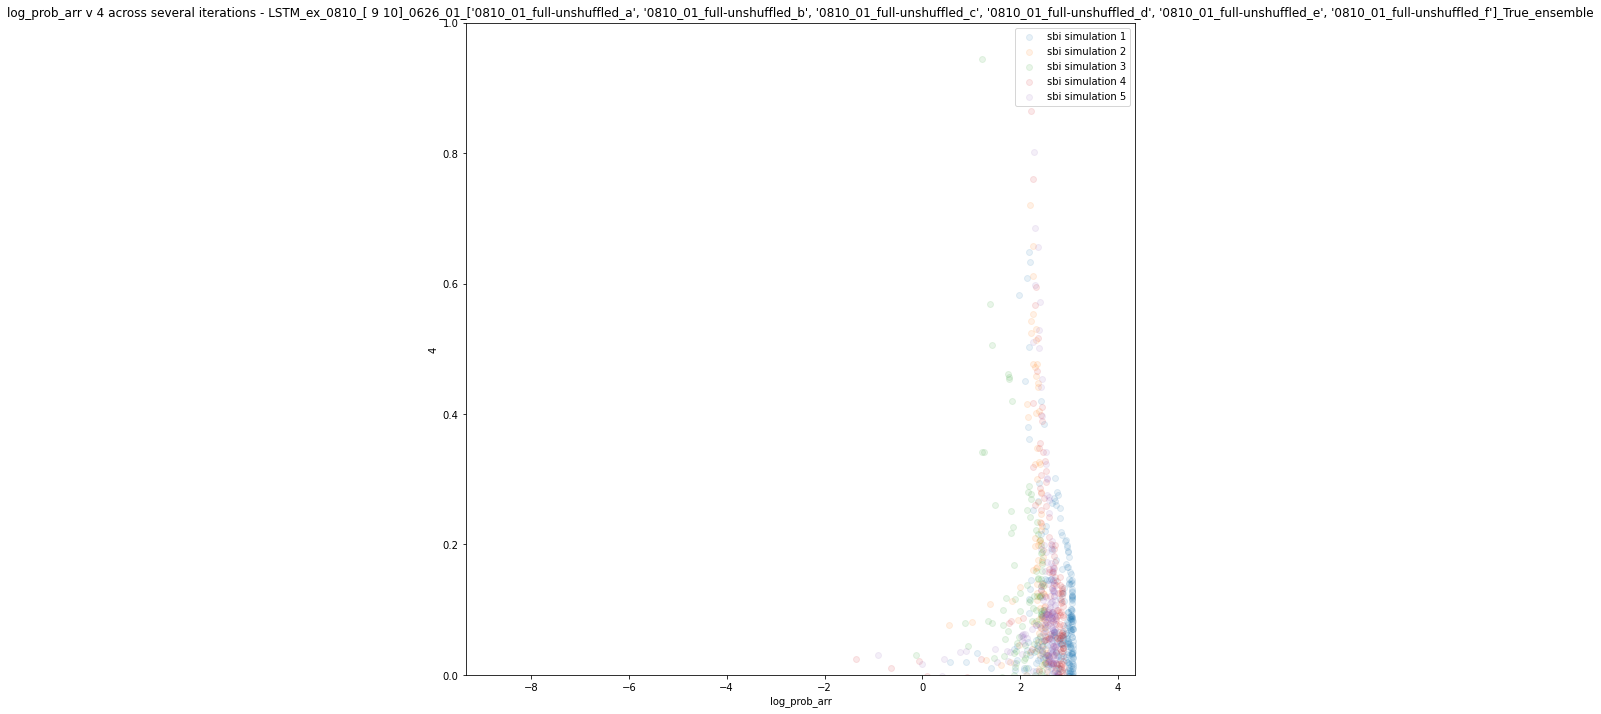

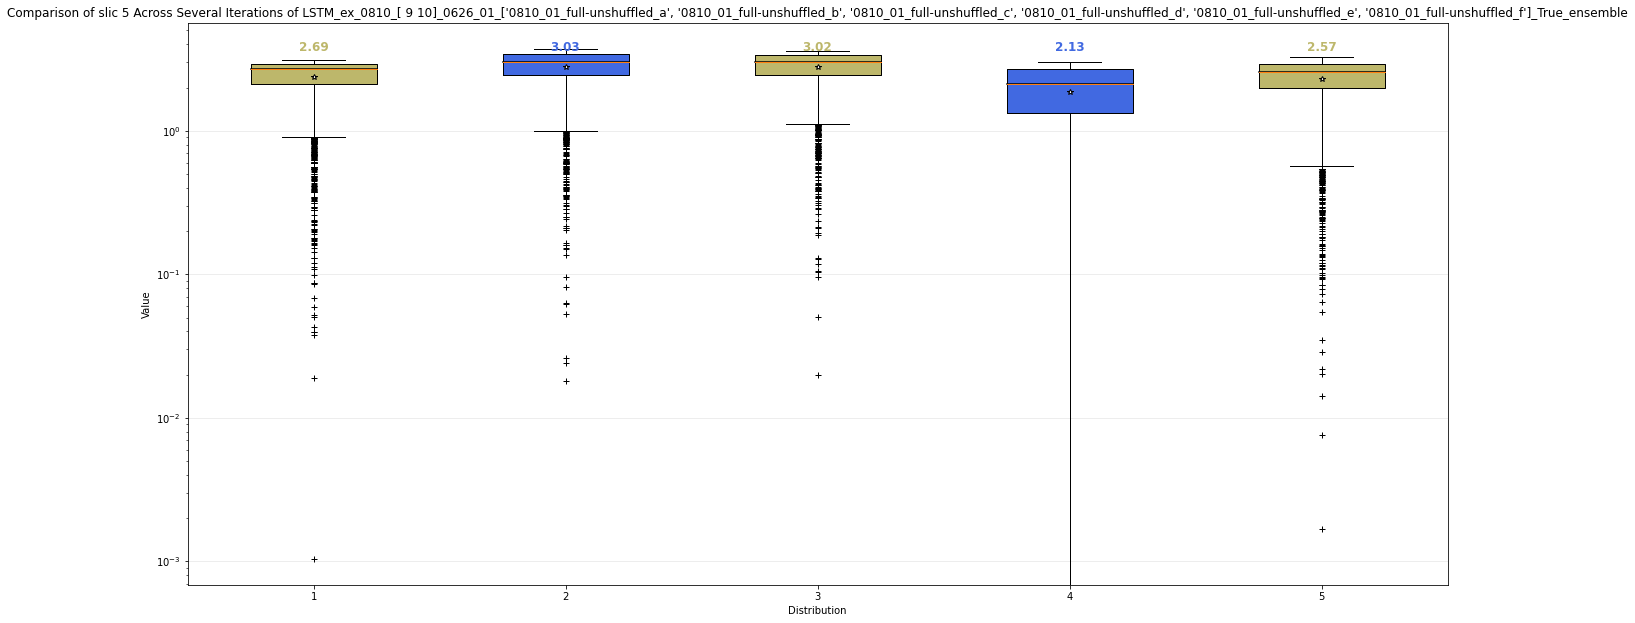

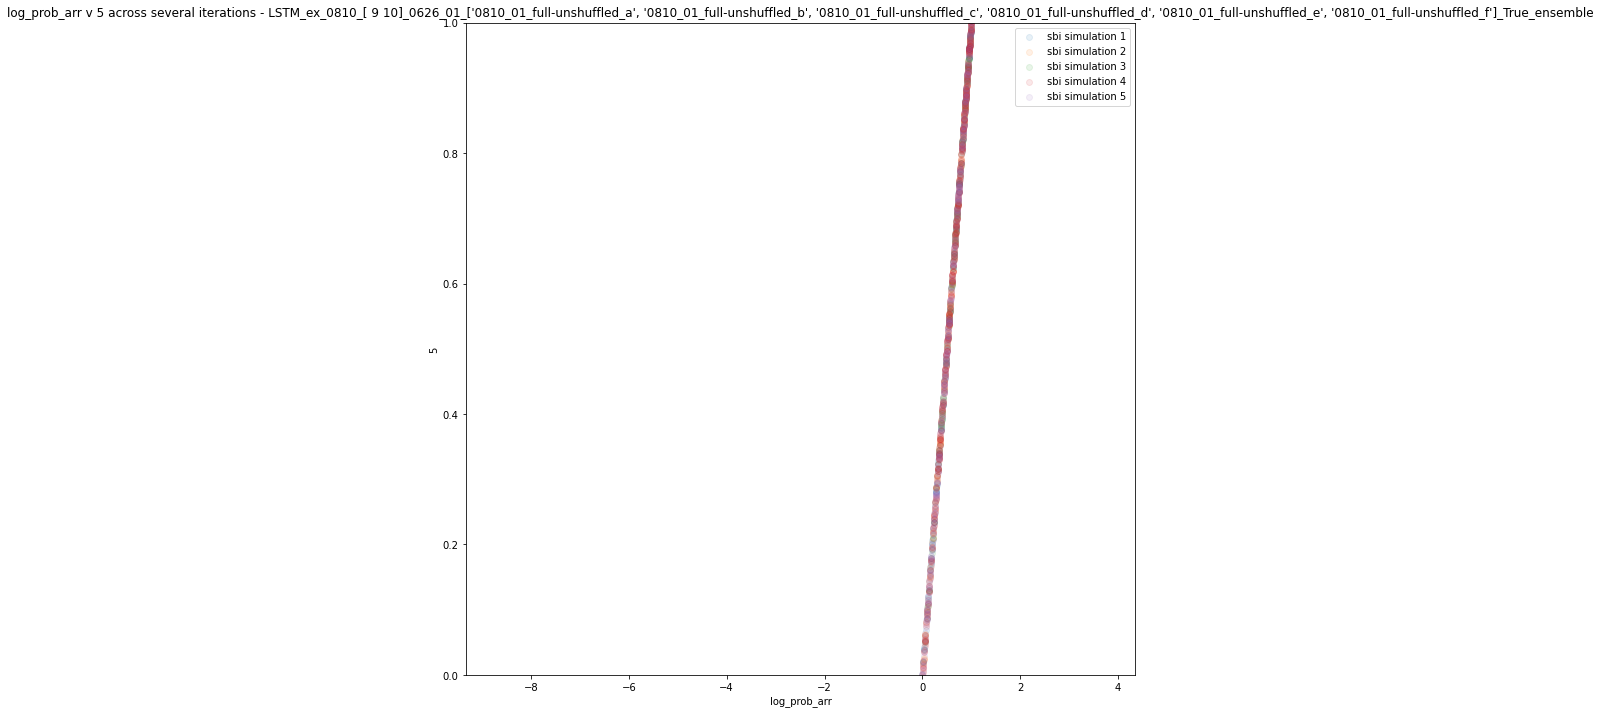

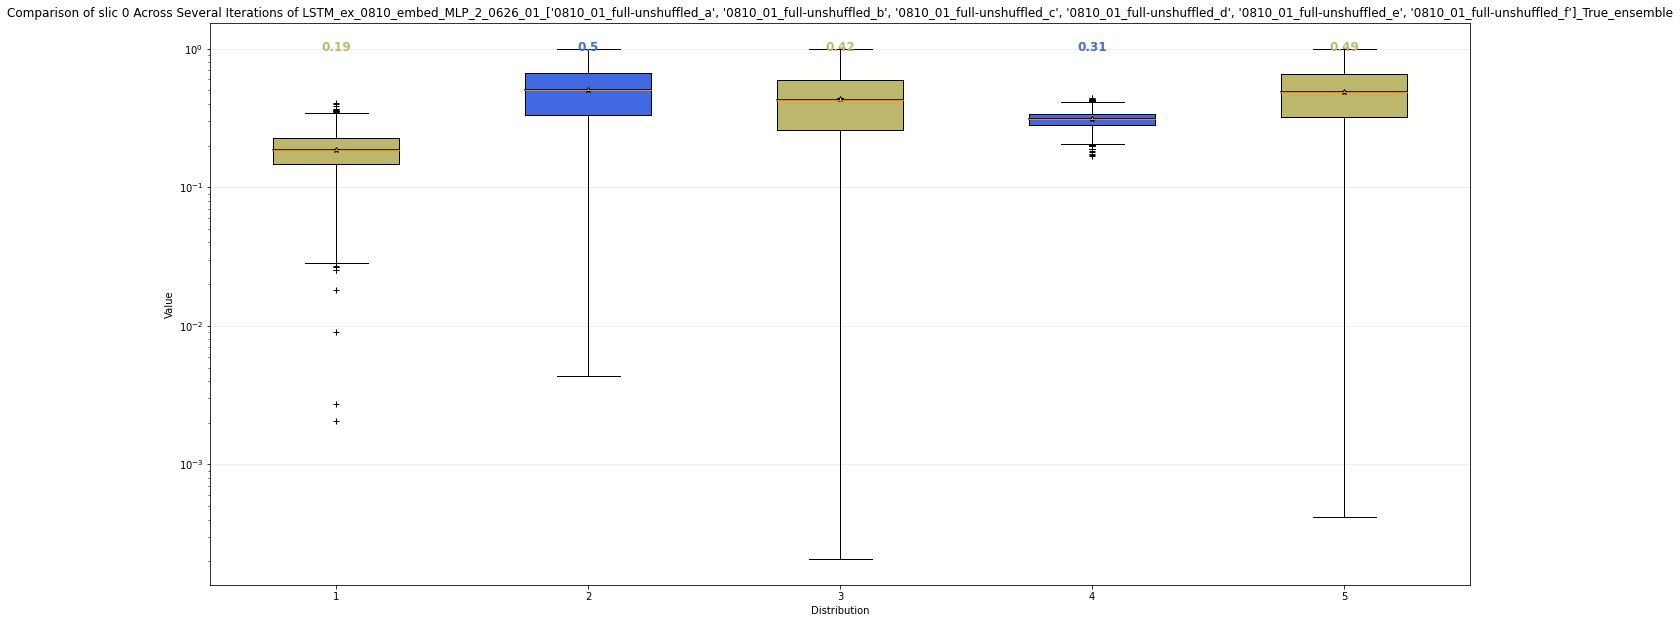

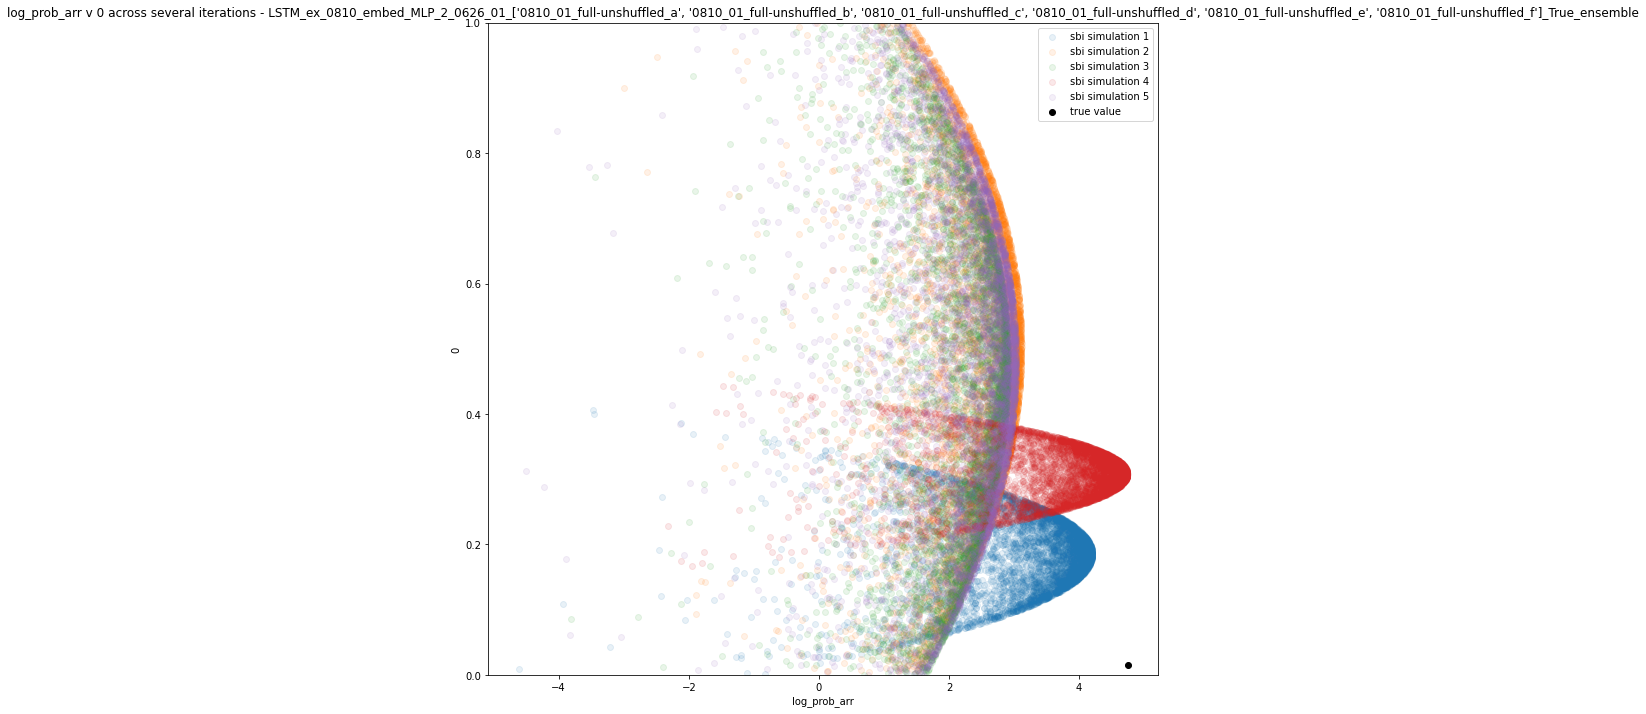

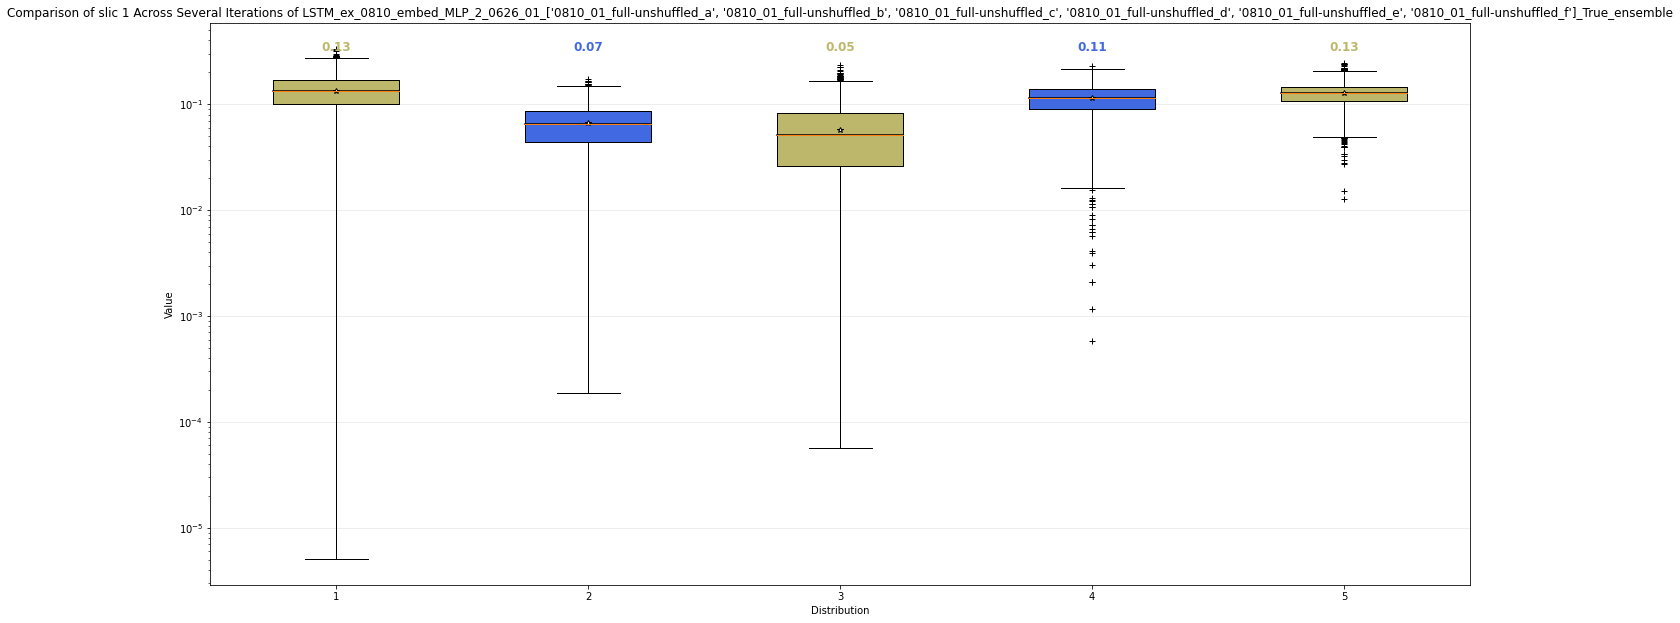

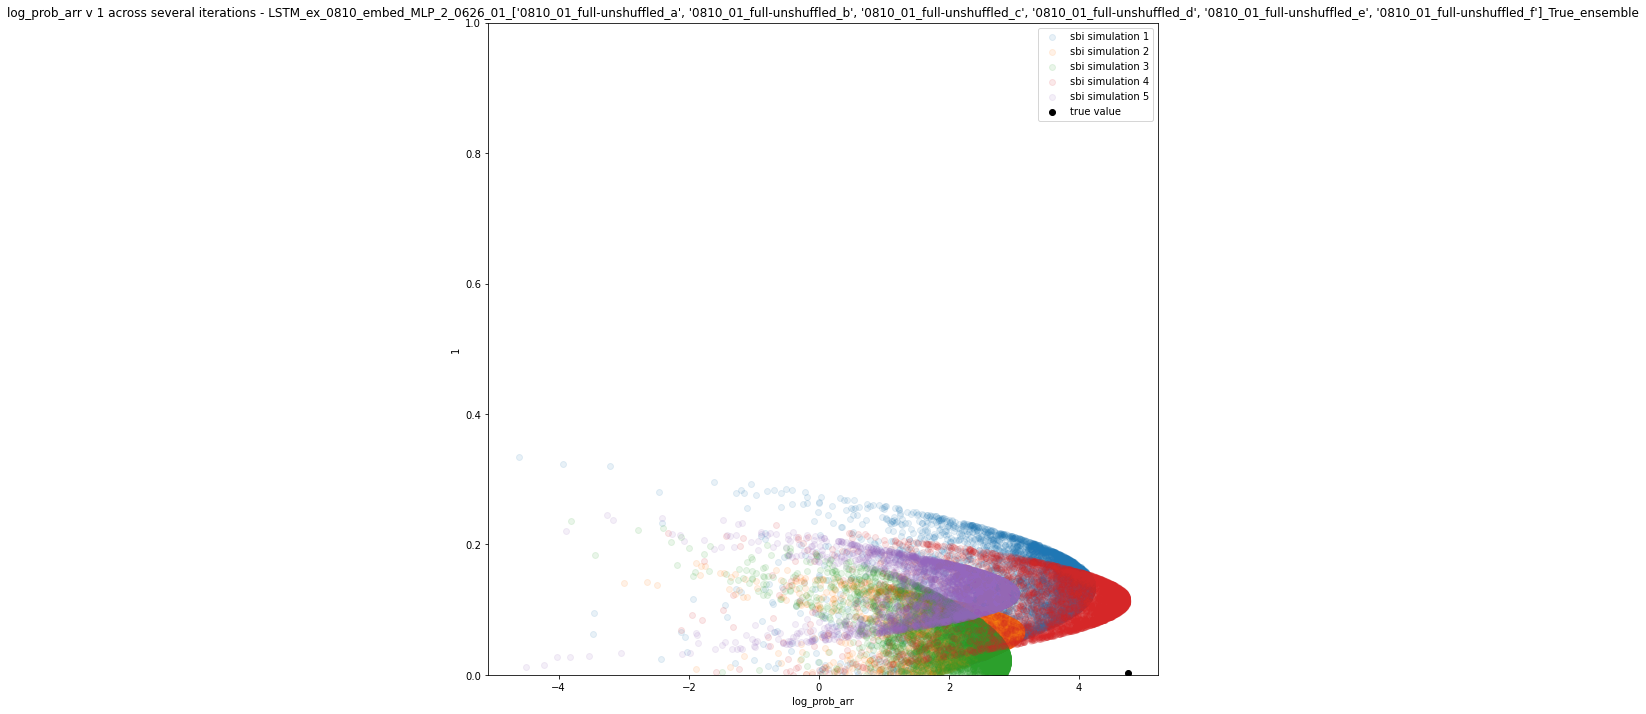

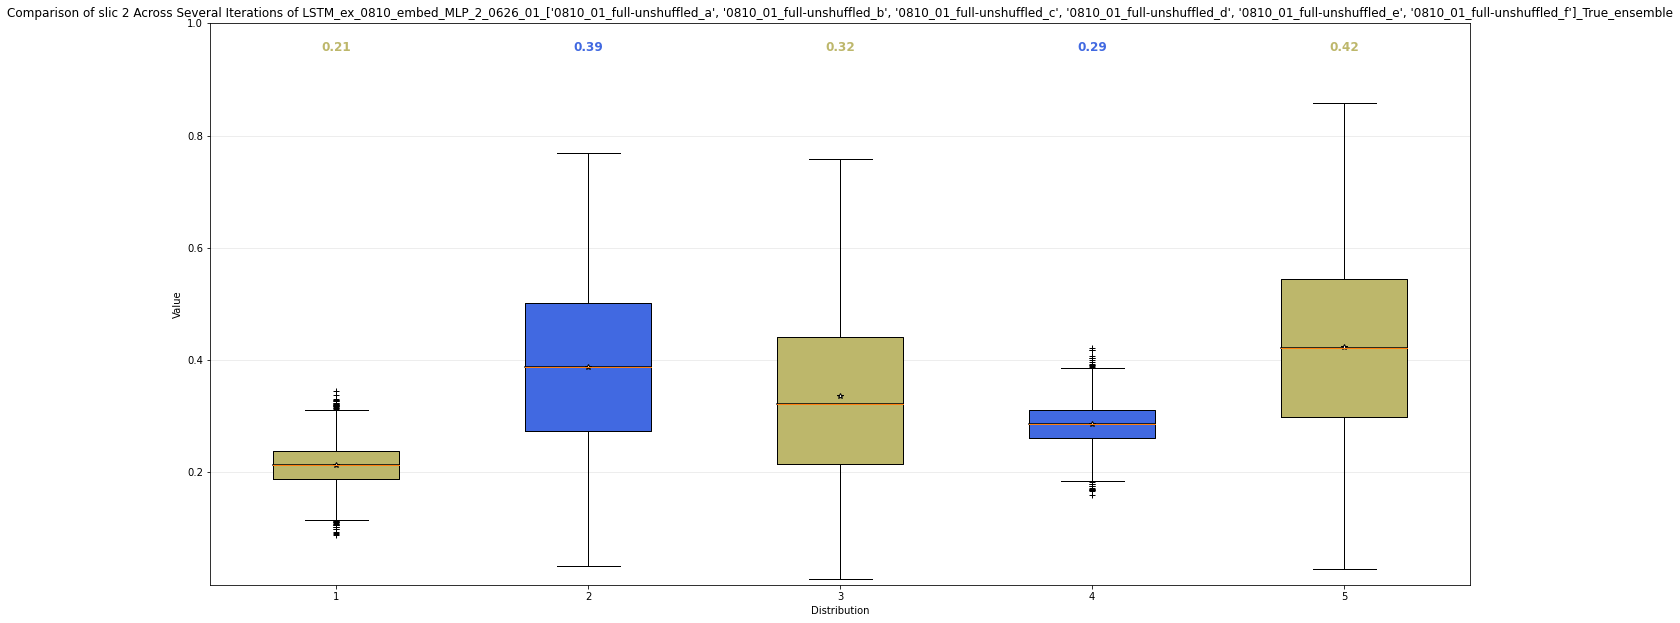

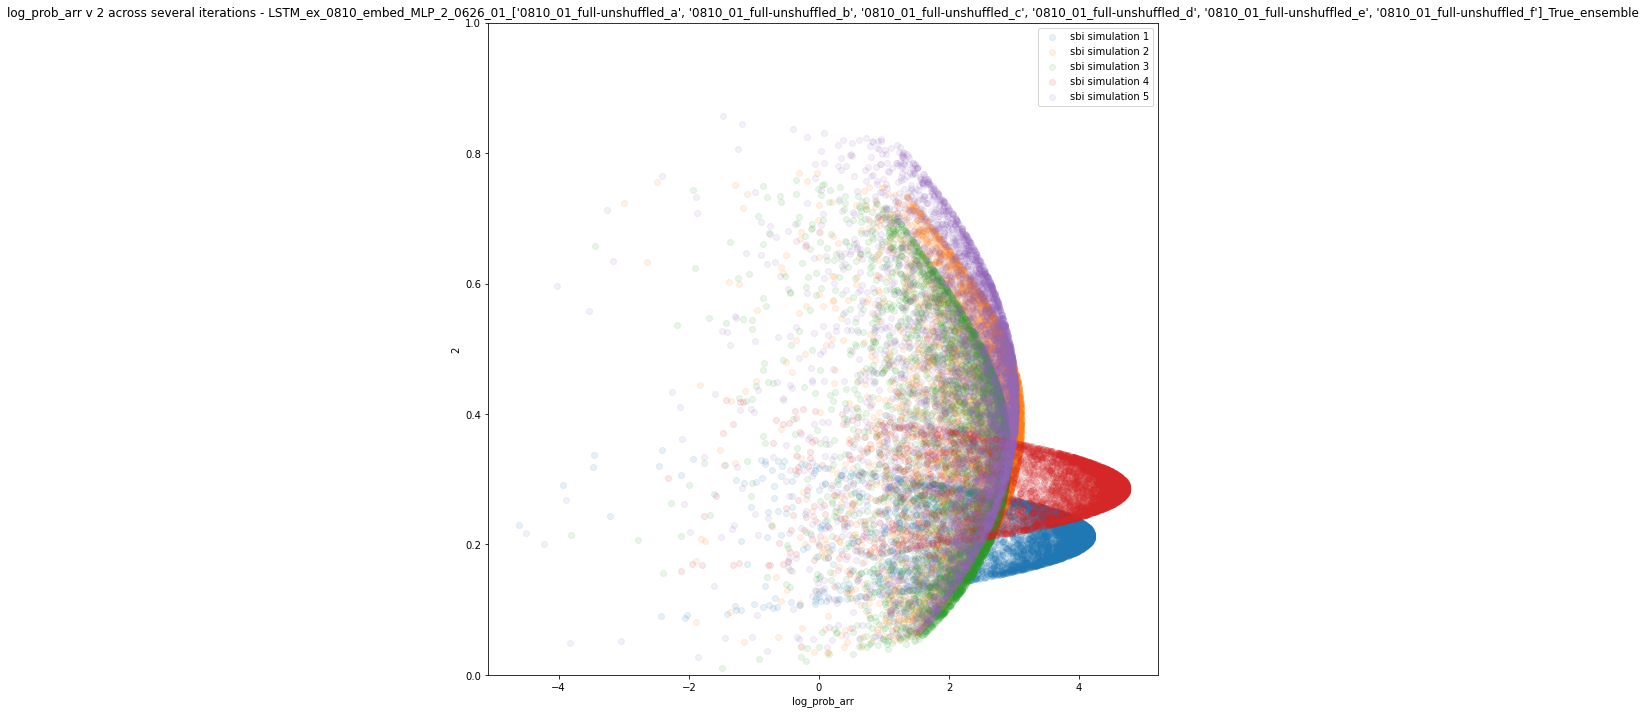

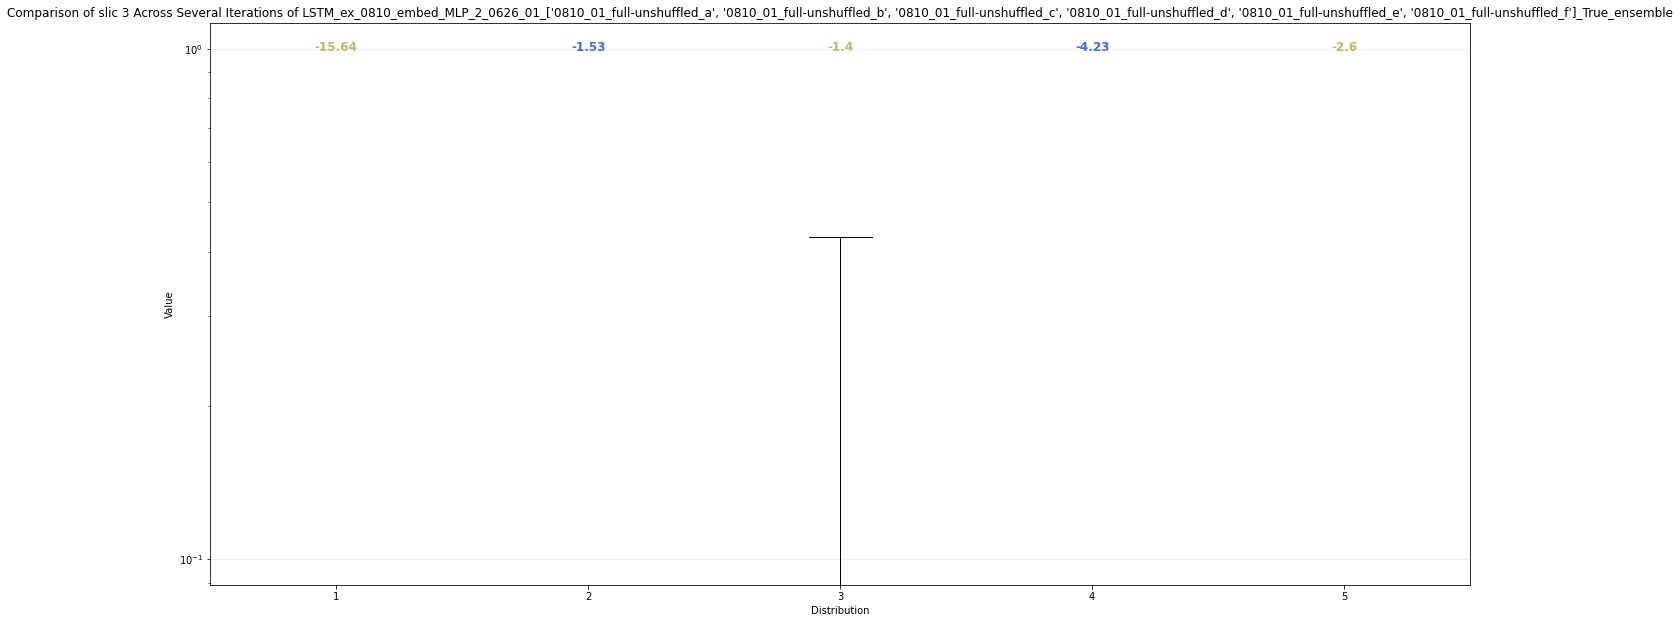

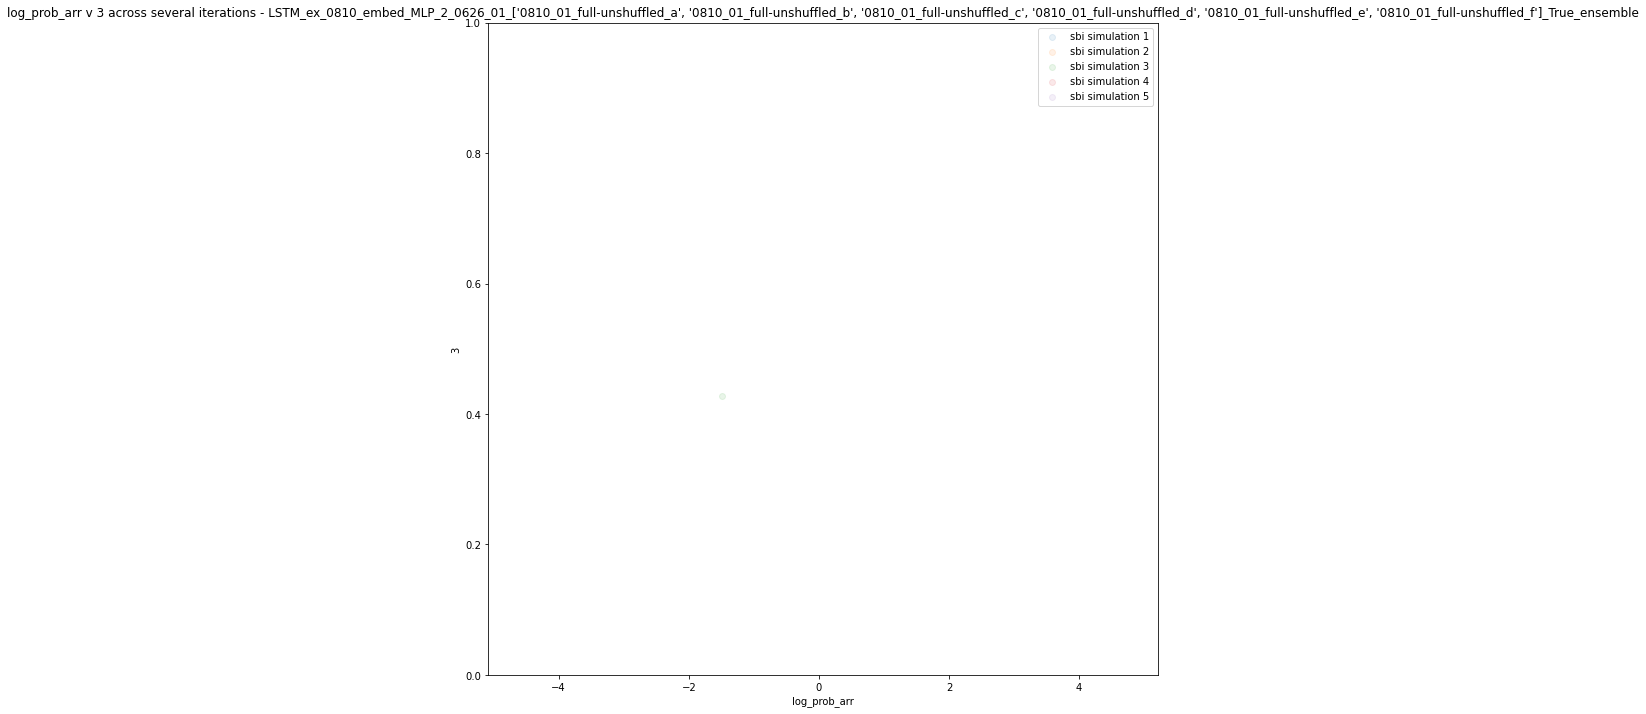

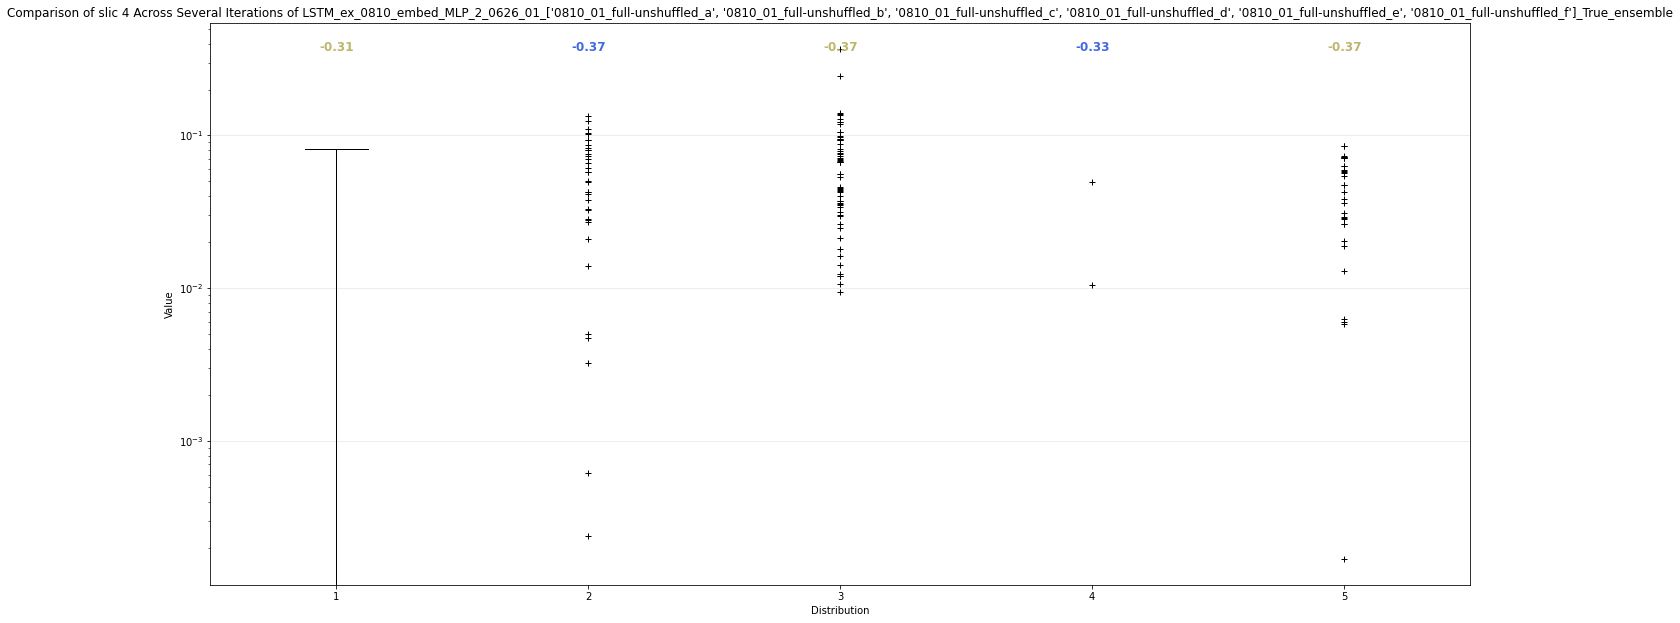

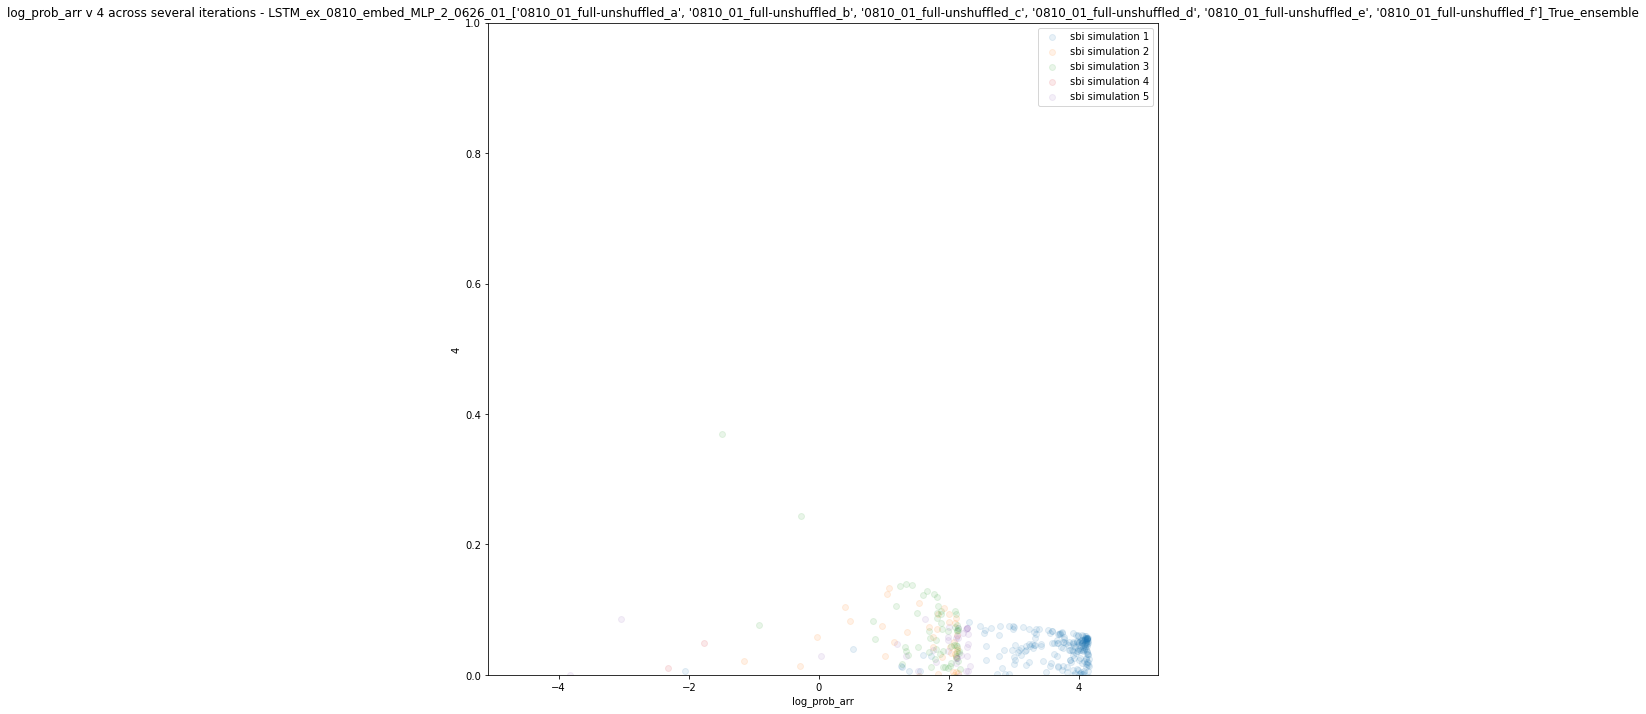

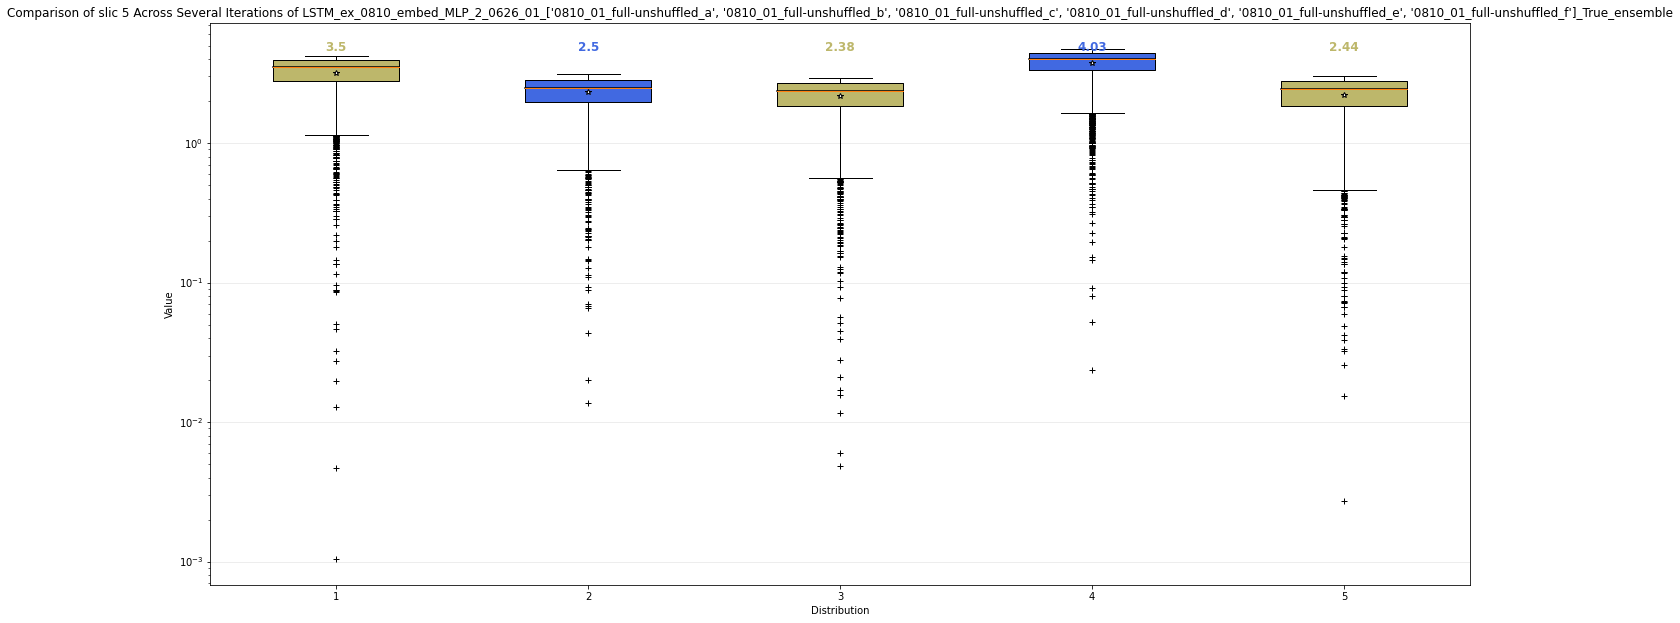

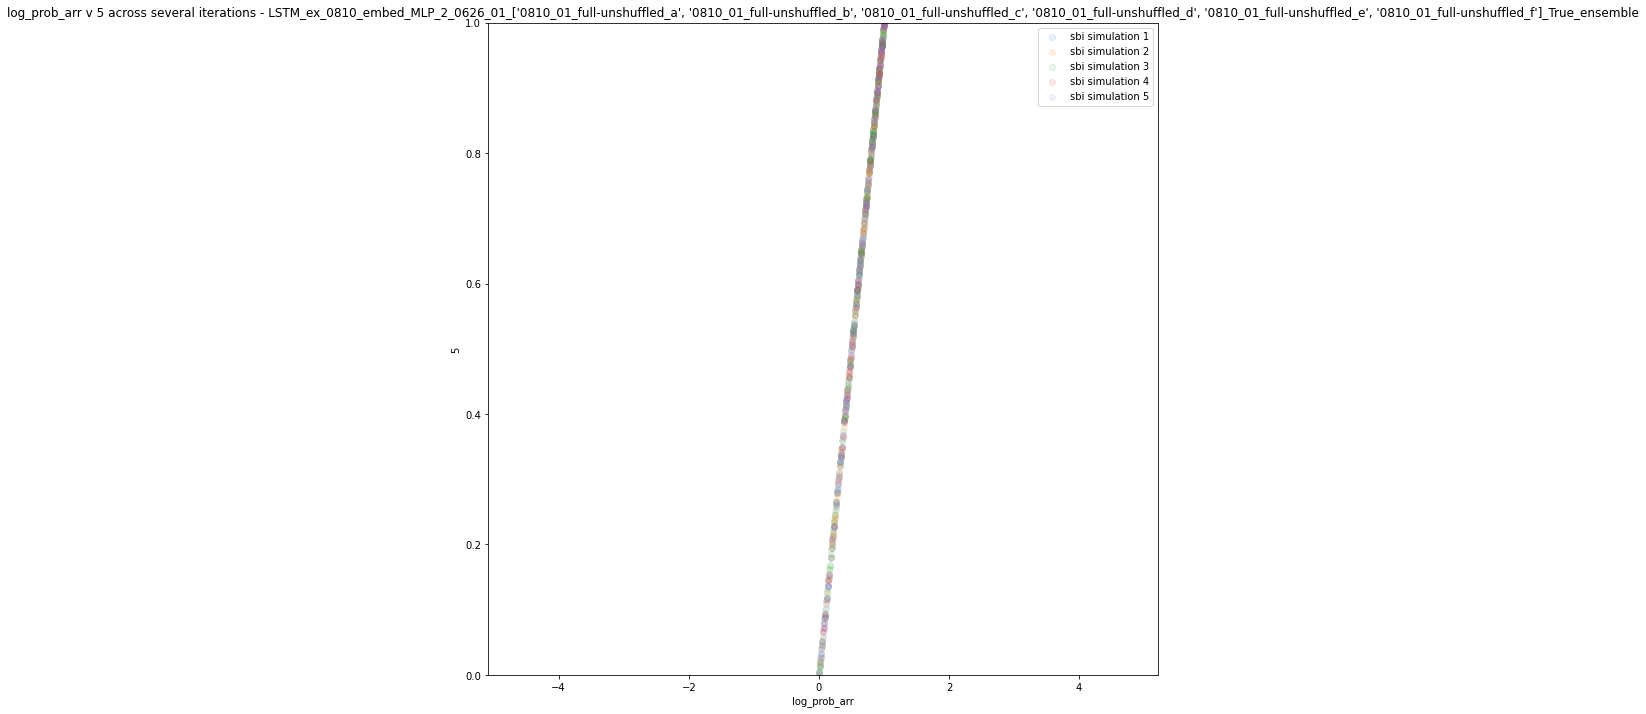

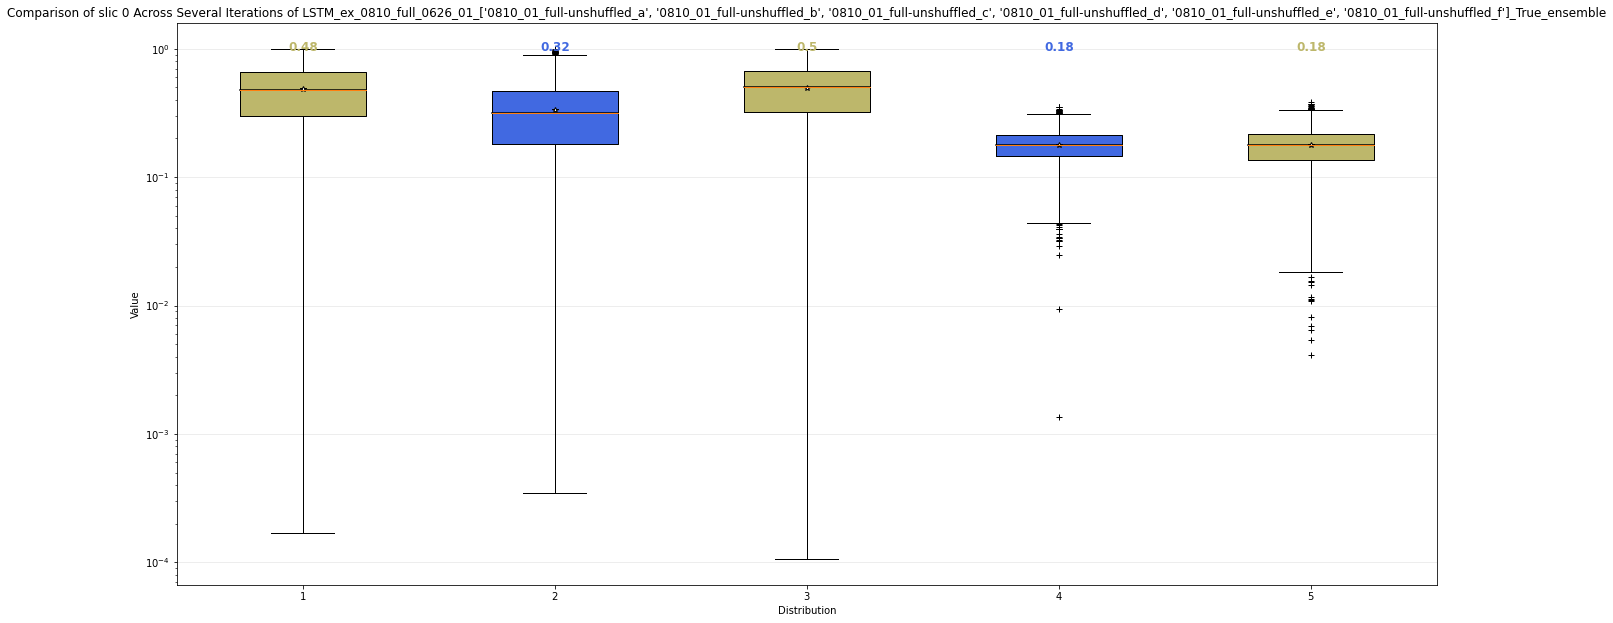

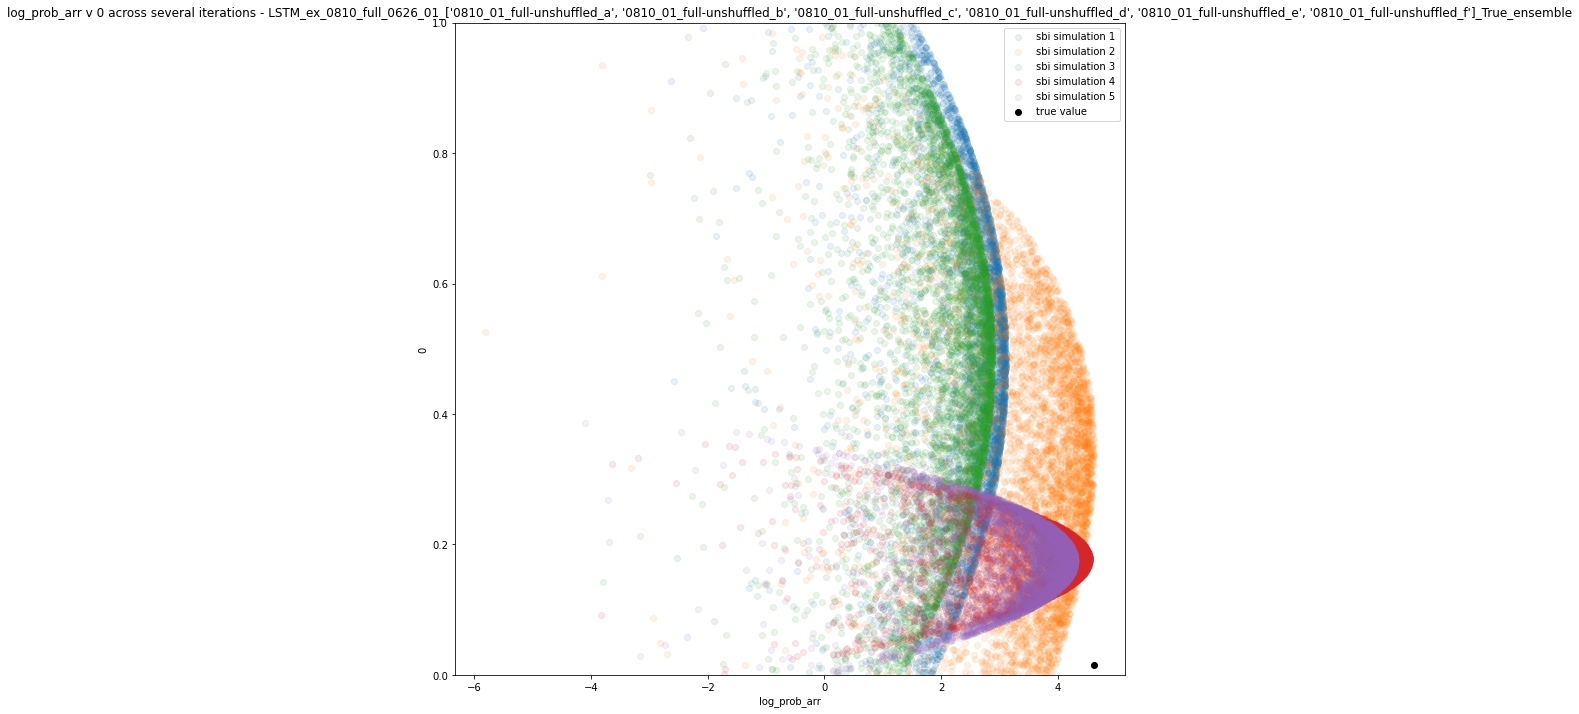

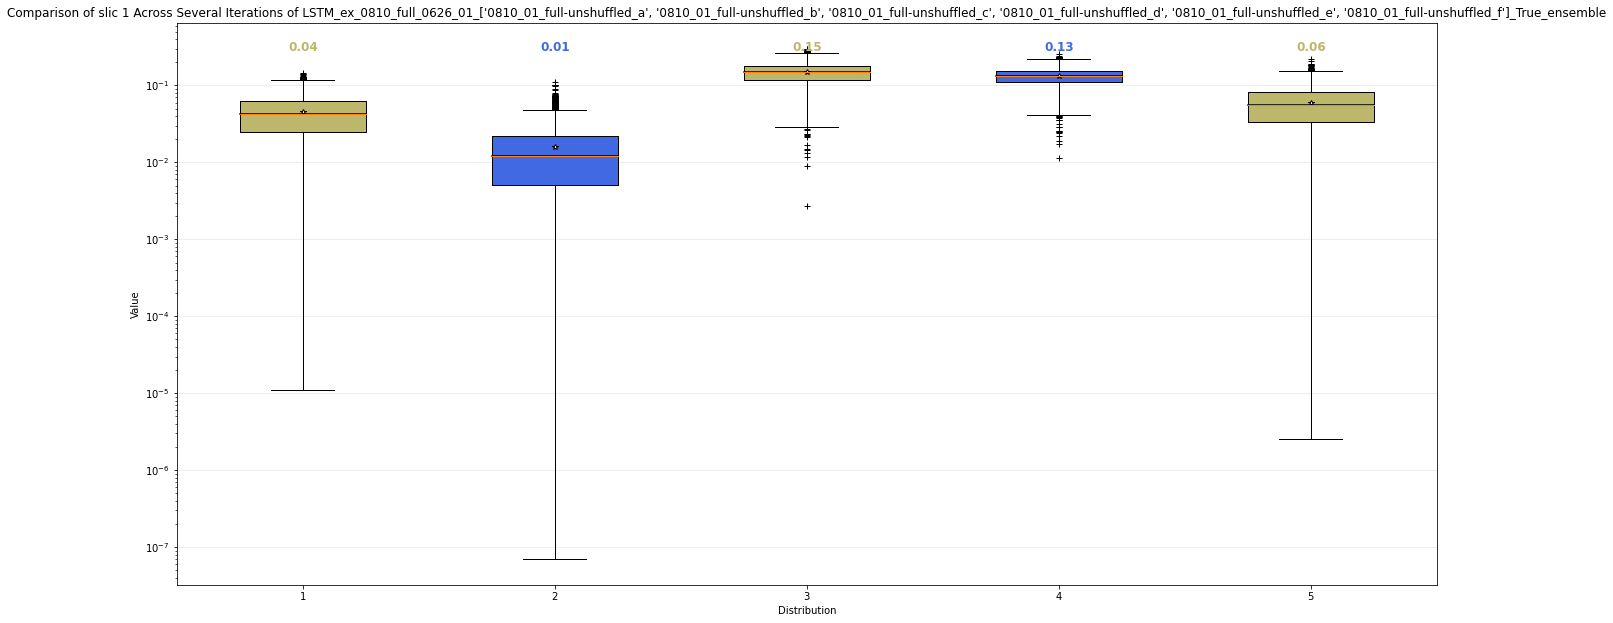

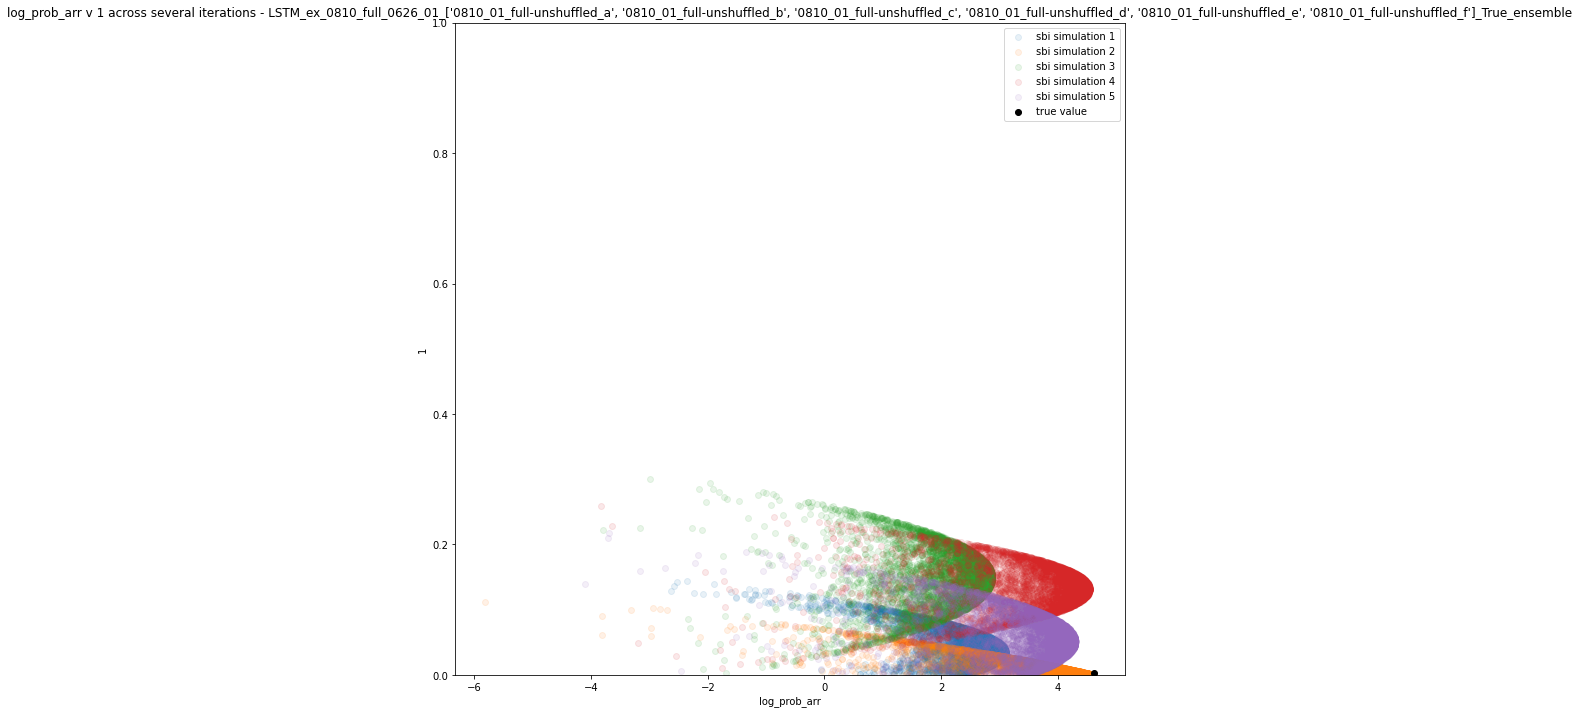

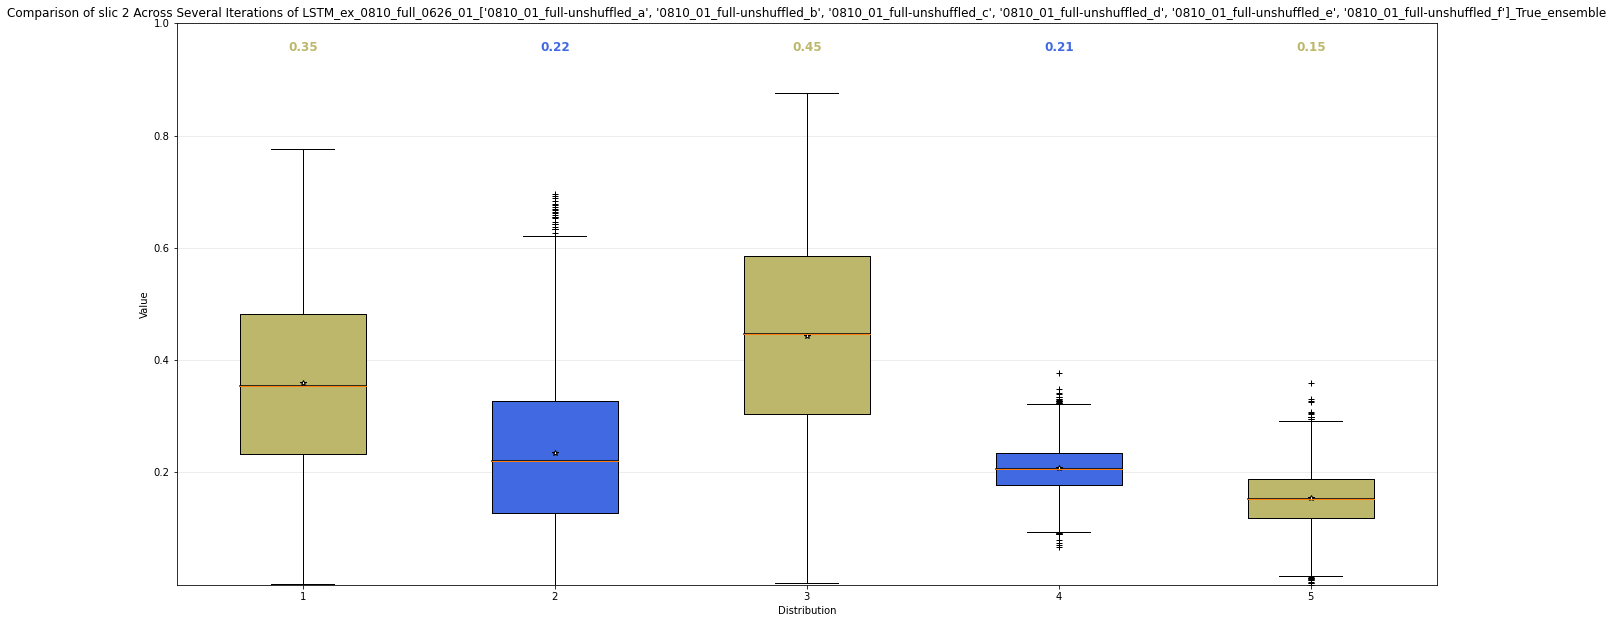

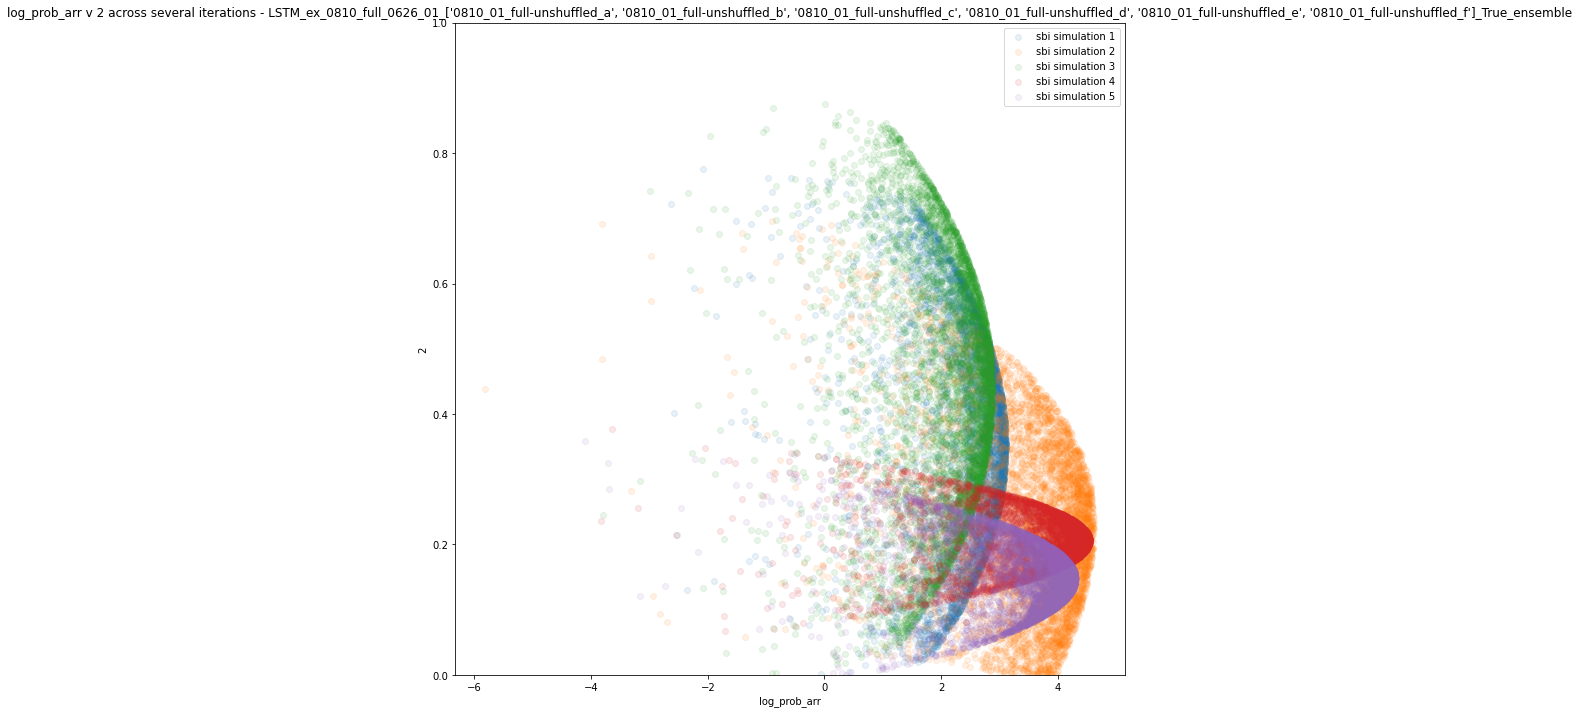

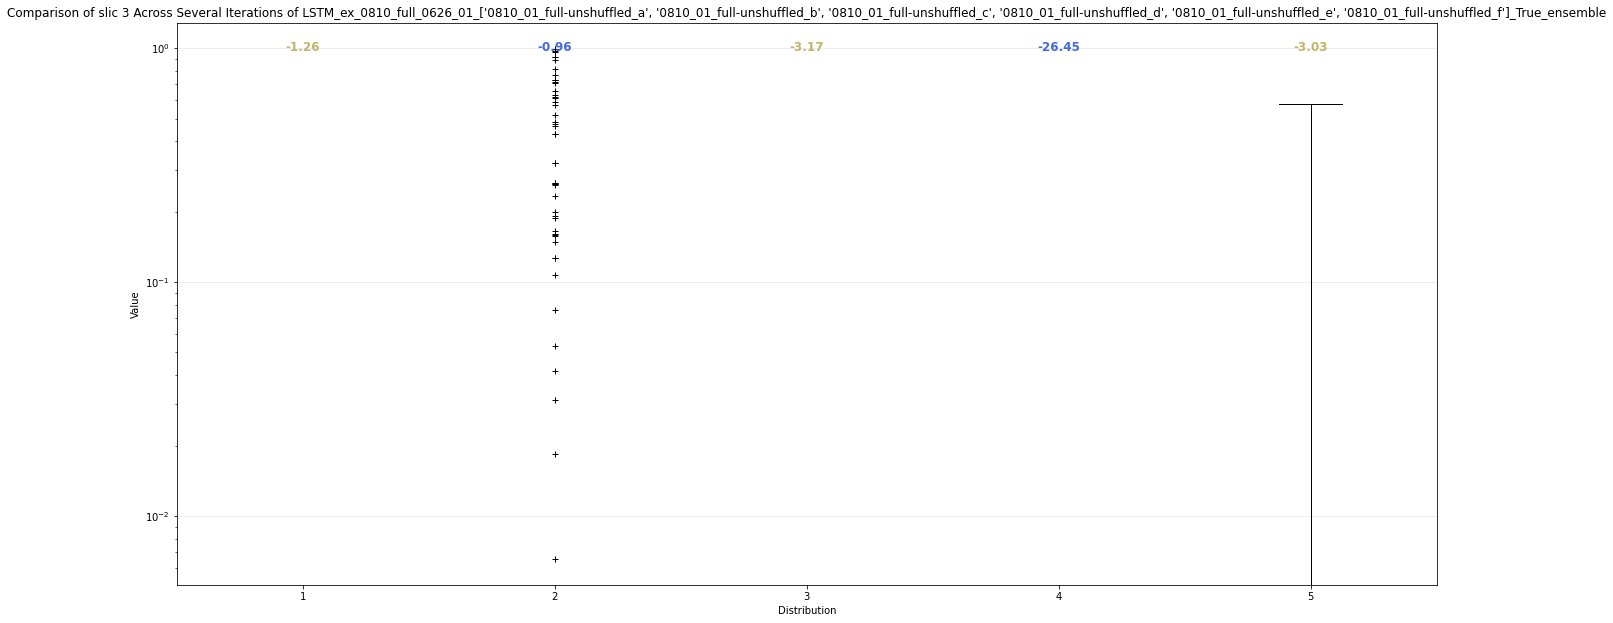

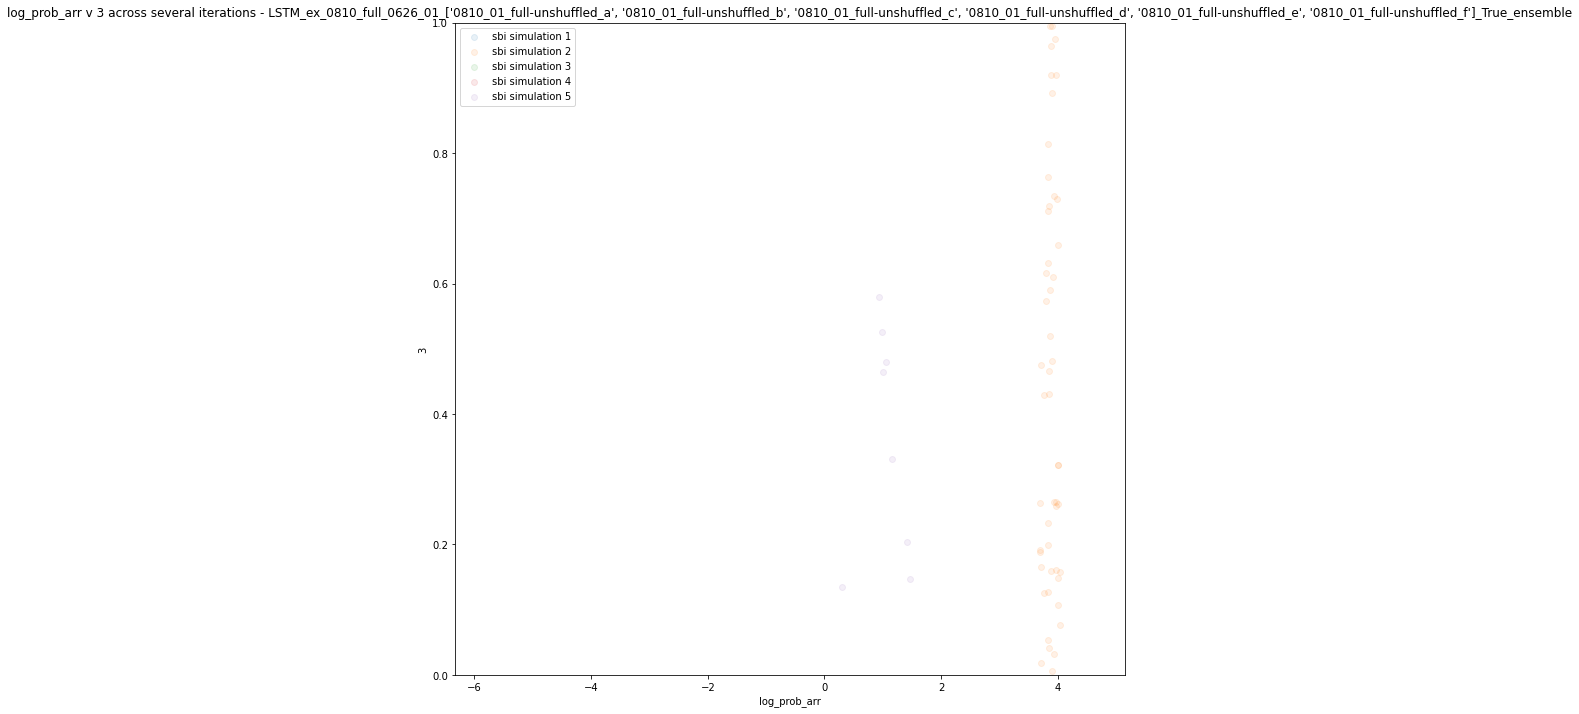

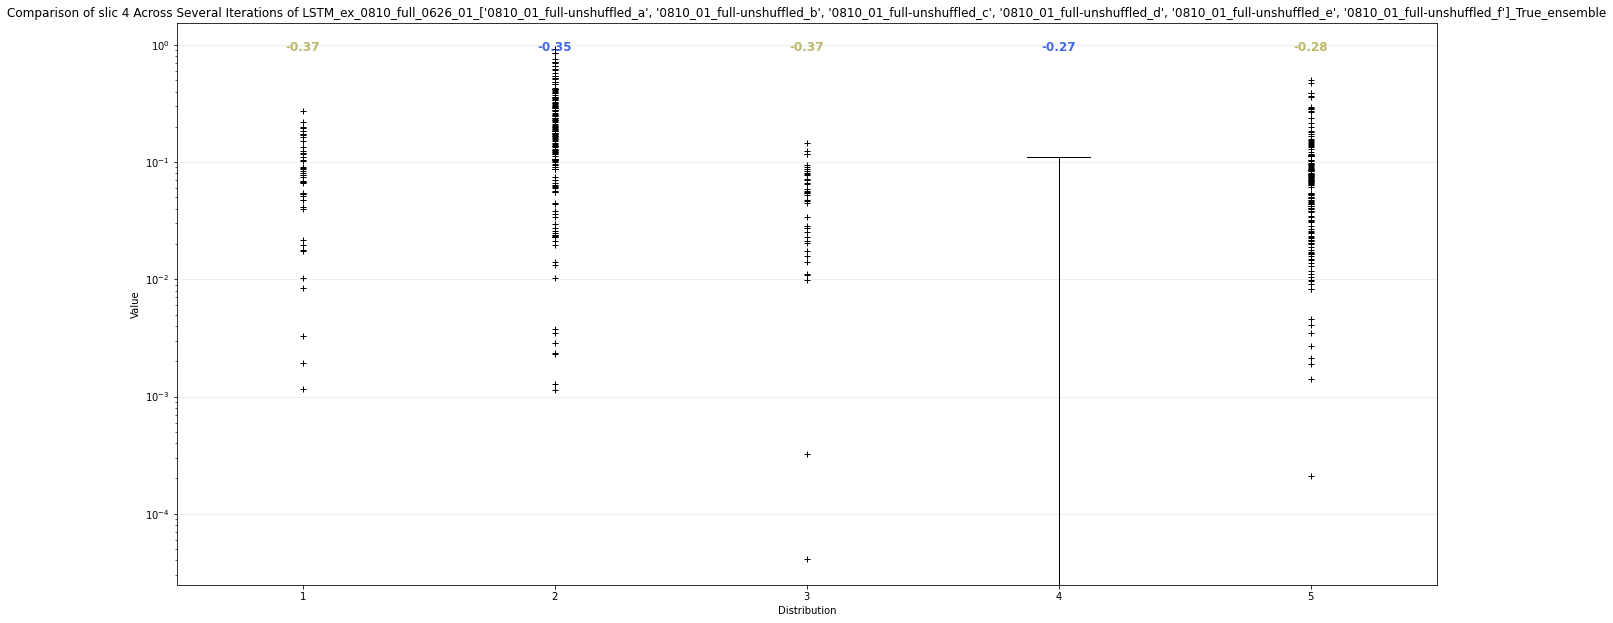

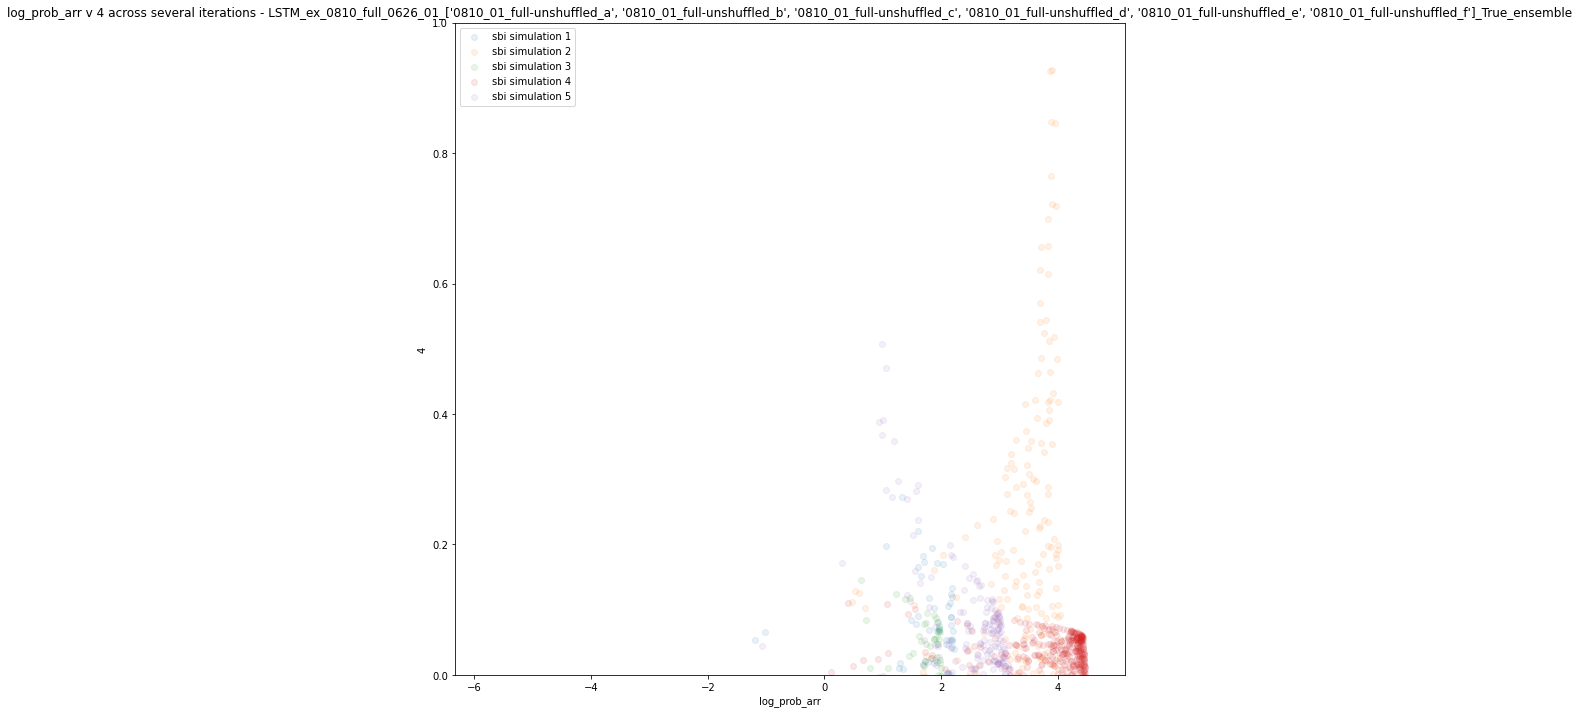

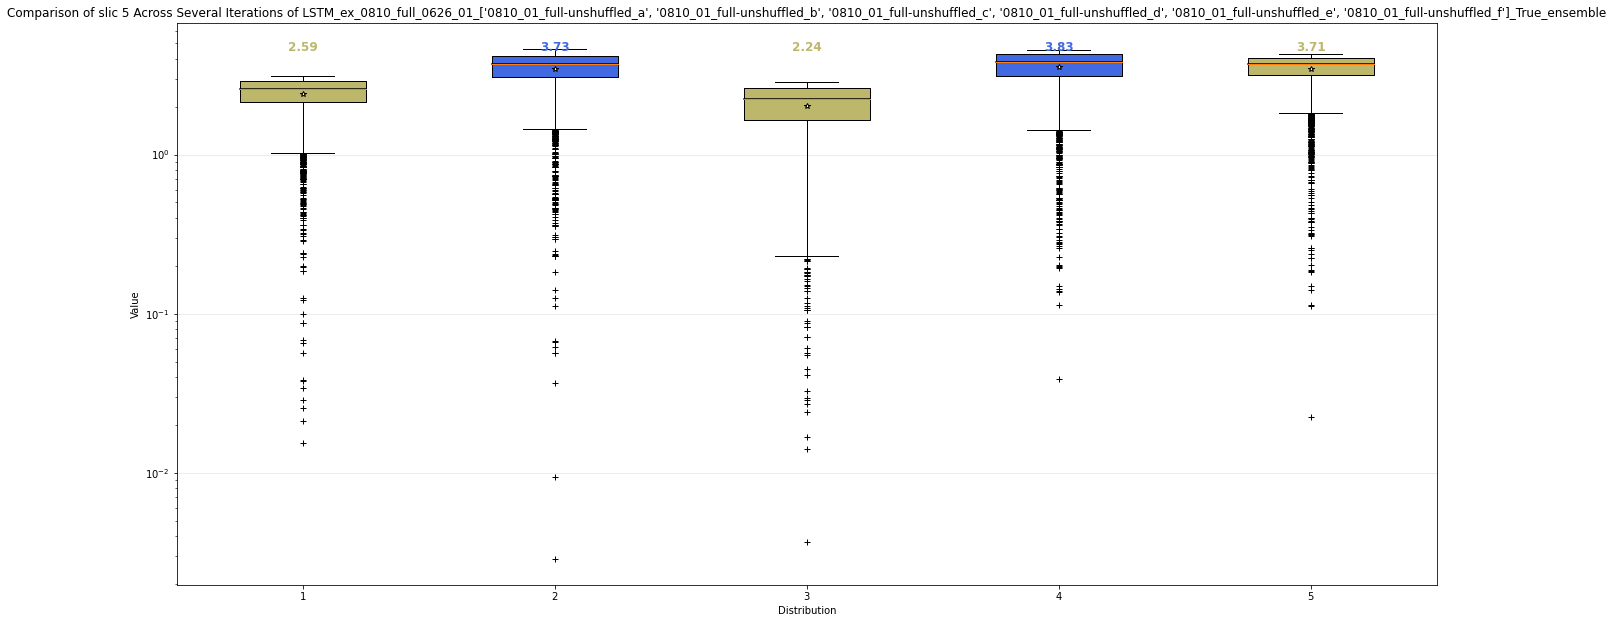

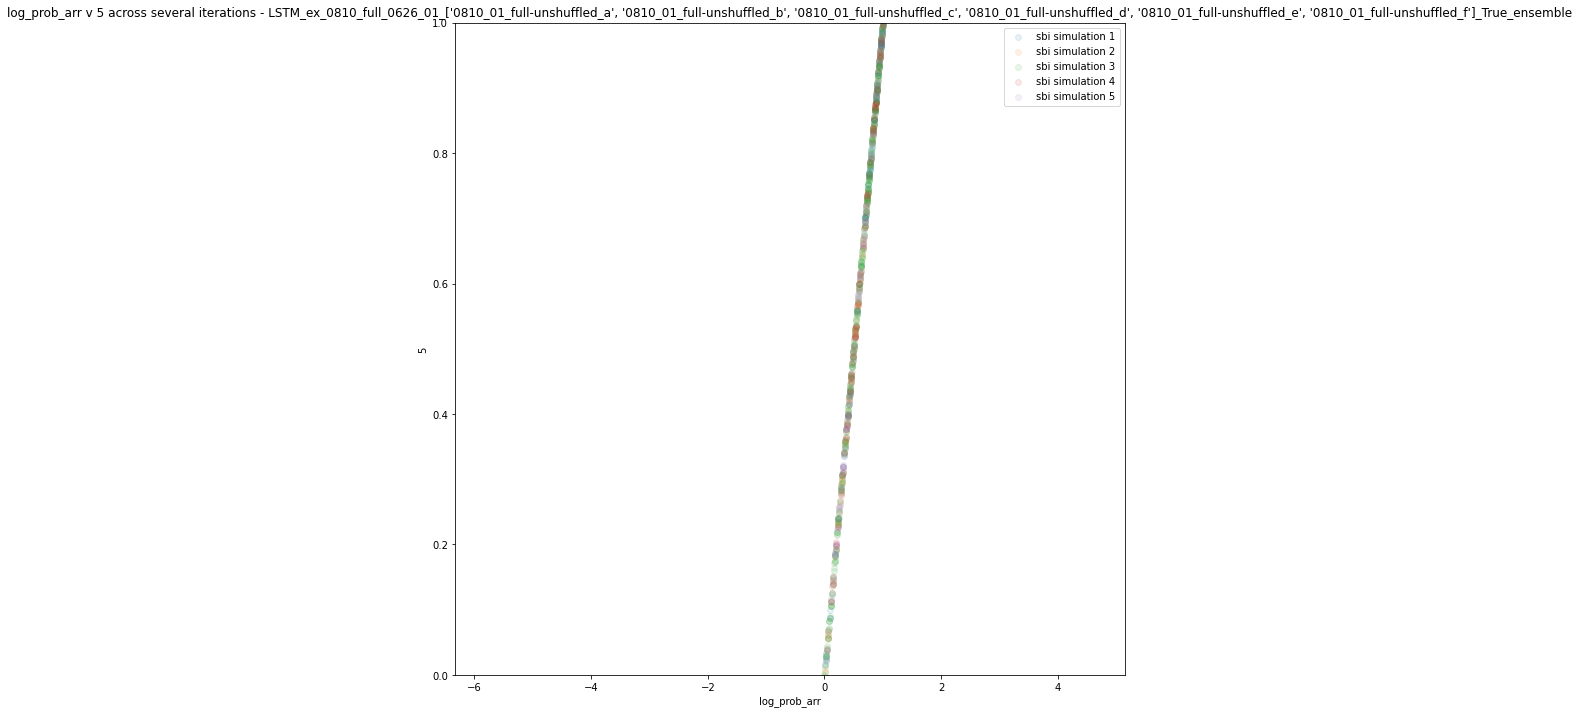

In [5]:
home_path = '/home/qh8373/UCRB/00_Principle_UCRB_Scripts/DELFI/'
scenario_root_list = ['''LSTM_ex_0810_[ 9 10]_0626_01_['0810_01_full-unshuffled_a', '0810_01_full-unshuffled_b', '0810_01_full-unshuffled_c', '0810_01_full-unshuffled_d', '0810_01_full-unshuffled_e', '0810_01_full-unshuffled_f']_True_ensemble''',
                '''LSTM_ex_0810_embed_MLP_2_0626_01_['0810_01_full-unshuffled_a', '0810_01_full-unshuffled_b', '0810_01_full-unshuffled_c', '0810_01_full-unshuffled_d', '0810_01_full-unshuffled_e', '0810_01_full-unshuffled_f']_True_ensemble''',
                '''LSTM_ex_0810_full_0626_01_['0810_01_full-unshuffled_a', '0810_01_full-unshuffled_b', '0810_01_full-unshuffled_c', '0810_01_full-unshuffled_d', '0810_01_full-unshuffled_e', '0810_01_full-unshuffled_f']_True_ensemble'''
                ]

save_path = 'LSTM_ex_0810_01_InterpretiveFigures/'
key = "*True* (scaled) Parameter Values" 

try:
    os.mkdir(f'{home_path}{save_path}')
except:
    print('warning: file exists')
    pass


warnings.filterwarnings("ignore")

for scenario_root in scenario_root_list:
    scenario_list = ['_a/', '_b/', '_c/', '_d/', '_e/']
    scen_code = scenario_root
    for i in range(len(scenario_list)): # len(scenario_list)
        scenario_list[i] = scenario_root+scenario_list[i]
    
    # set up global arrays:
    log_prob_arr = appendArray(home_path, scenario_list, slic=5)
    rmse_arr = appendArray(home_path, scenario_list, slic=2)
    
    # slic: 0 - param1, 1 - param2, 2-rmse, 3-nse, 4-kge, 5-logprob
    for slic in range(6): # 6
        #set up plotting arrays
        plt_list = _readArray(home_path, scenario_list, slic=slic)
        plot_arr = appendArray(home_path, scenario_list, slic=slic)
        if (slic == 0) or (slic ==1):
            trueval = realParams(home_path+scenario_list[0], key)[slic]
        else:
            trueval = False

        # make a box plot
        save_path_b = f'{home_path}{save_path}{scenario_root}_box_{slic}'
        makeScenarioBox(plt_list, slic, scen_code,save=True,save_path=save_path_b)


        # make 2D plot
        save_path_s = f'{home_path}{save_path}{scenario_root}_scatter_{slic}'
        dim_2_scatter(arr_x=log_prob_arr, plot_arr=plot_arr, slic_x='log_prob_arr',
                    slic_y=slic, scen_code=scen_code, trueval=trueval,
                     save=True, save_path=save_path_s)


            
        



In [53]:
# filter out log probability arry, theta array, and theta 2 array
idx_m, idx_ma = 20000, 25000
log_prob_play = log_prob_arr[idx_m:idx_ma,0]

theta_1 = realParams(home_path+scenario_list[0], key)[0]
theta_1_arr = appendArray(home_path, scenario_list, slic=0)[idx_m:idx_ma,0]
theta_2 = realParams(home_path+scenario_list[0], key)[1]
theta_2_arr = appendArray(home_path, scenario_list, slic=1)[idx_m:idx_ma,0]


# find out the locations of true theta according to criterion
theta_1_prec, theta_2_prec = 3, 4
theta_1_idx = np.where(np.round(theta_1_arr, theta_1_prec) == np.round(theta_1, theta_1_prec))
theta_2_idx = np.where(np.round(theta_2_arr, theta_2_prec) == np.round(theta_2, theta_2_prec))

# find acceptable thetas
theta_1_acc = np.take(theta_1_arr, theta_1_idx)
theta_2_acc = np.take(theta_2_arr, theta_2_idx)

# find the log probability of theta 1 and theta 2
log_prob_theta_1 = np.take(log_prob_play, theta_1_idx)
log_prob_theta_2 = np.take(log_prob_play, theta_2_idx)

print(theta_1)
# print(theta_1_acc)
# print('')
# print(theta_2)
# print(theta_2_acc)
# print(log_prob_theta_1)
# print(log_prob_theta_2)
# print(theta_1_idx)
# print(theta_2_idx)

# print a conditional statement to represent the goodness of fit
print()
print('The average log probability of theta_1 is', log_prob_theta_1[0].mean(), 'within a precision of', theta_1_prec)
print('The average log probability of theta_2 is', log_prob_theta_2[0].mean(), 'within a precision of', theta_2_prec)
# print(theta_1_idx[0]==theta_2_idx[0])
# print(np.intersect1d(np.array([1,3,4]), np.array([3,6,7])))
# print(np.intersect1d(theta_1_idx[0], theta_2_idx[0]))
if len(np.intersect1d(theta_1_idx[0], theta_2_idx[0])) !=0:
    print('overlap exists')
else:
    print('There is no overlapping area where theta_1 and theta_2 are probable in the sample space')
    print('The probability of true theta values', theta_1, theta_2, 'is <', np.min(log_prob_play))
    
    
# find the maximum probability 
log_prob_max = log_prob_play.max()
log_prob_max_idx = np.where(log_prob_play == log_prob_max)
theta_1_max_prob, theta_2_max_prob = np.take(theta_1_arr, log_prob_max_idx), np.take(theta_2_arr, log_prob_max_idx)

# print(log_prob_max)
# print(log_prob_max_idx)
print('')
print('The maximum probability is', log_prob_max)
print('The maximum probability theta is', theta_1_max_prob, theta_2_max_prob)

# find the mode of theta_1 and theta_2
theta_1_mode, theta_2_mode = mode(np.round(theta_1_arr, theta_1_prec)), mode(np.round(theta_2_arr, theta_2_prec))
print('')
print('The mode theta is', theta_1_mode[0], theta_2_mode[0])

# take a random sample
idx_random = random.randint(0, len(log_prob_play)-1)
theta_1_rand, theta_2_rand = theta_1_arr[idx_random], theta_2_arr[idx_random]
log_prob_rand = log_prob_play[idx_random]
print('')
print('A randomly sampled theta pair is', theta_1_rand, theta_2_rand)
print('The probability of this theta pair is', log_prob_rand)



0.015742799279927992

The average log probability of theta_1 is 0.4278307259082794 within a precision of 3
The average log probability of theta_2 is 3.2208237648010254 within a precision of 4
There is no overlapping area where theta_1 and theta_2 are probable in the sample space
The probability of true theta values 0.015742799279927992 0.0023002300230023 is < -4.106434345245361

The maximum probability is 4.303979873657227
The maximum probability theta is [[0.17504033]] [[0.0511864]]

The mode theta is [0.175] [0.0477]

A randomly sampled theta pair is 0.1815733164548874 0.11308810114860535
The probability of this theta pair is 3.1895790100097656


# How to explore the results of Bayesian Models in Python 
* https://joss.theoj.org/papers/10.21105/joss.01143
* https://github.com/mackelab/sbi/issues/379
    Dalmasso et al. 2020 describe a diagnostic for methods approximating the likelihood, e.g. SNLE/SNL
    Hermans et al. 2020 describe a ROC diagnostic in section 3.2 of the paper for SNRE/AALR
    Simulation-based calibration (SBC, Talts et al. 2018). Since SBC requires inference for many observations, this would probably only work for NPE, i.e., single-round posterior estimation
    Diagnostics to check whether x_o is in-distribution wrt to the training dataset
    Convergence of neural network loss function
    Mixing of MCMC chains, R hat, autocorrelations
    Posterior predictive plots
* https://github.com/mackelab/sbi/issues/424

In [ ]:
print(f'{home_path}{save_path}')

In [ ]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
x1 = np.ones((10,10))*trueK
y2 = np.ones((10,10))*trueM
x2, y1, z = np.outer(np.linspace(0, 1, 10), np.ones(10)), np.outer(np.linspace(0, 1, 10), np.ones(10)), np.outer(np.linspace(-5, 5, 10), np.ones(10))# np.meshgrid(np.linspace(-5, 5, 10), np.ones(10), range(10), range(10)) # np.outer(np.linspace(-5, 5, 10), np.ones(10))


fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(x1, y1, z,cmap='viridis', edgecolor='none')
ax.plot_surface(x2, y2, z,cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
plt.show()

In [ ]:
#     # 2D plot 
#     fig, ax2 = plt.subplots(figsize=(12, 12))
#     for i in np.unique(log_prob_arr[:,1]):
#         idx = int(i)
#         filtr = np.where(log_prob_arr[:,1] == idx)
#         ax2.scatter(log_prob_arr[filtr,0], rmse_arr[filtr,0], alpha=0.1, label=f'sbi simulation {idx + 1}')

#     ax2.set_title(f'Parameter RMSE v log Probability across several iterations - {scen_code}')
#     ax2.set_xlabel('LOG PROB ? <- less probable     more probable ->  ')
#     ax2.set_ylabel('RMSE <-  better fit    worse fit -> ')
#     ax2.set_ylim(0, 1)
#     ax2.set_xlim(-6, 6)
#     # ax2.set_xlim(-8, 8)
#     # ax2.set_xscale('log')
#     # ax2.set_yscale('log')
#     plt.legend()
#     plt.show()

#     # 3D plot
#     fig = plt.figure(figsize=(12,12))
#     ax3 = fig.add_subplot(projection='3d')

#     for i in np.unique(log_prob_arr[:,1]):
#         idx = int(i)
#         filtr = np.where(log_prob_arr[:,1] == idx)
#         ax3.scatter(k_arr[filtr,0], m_arr[filtr,0], log_prob_arr[filtr,0], alpha=0.01, label=f'sbi simulation {idx + 1}')

#     ax3.scatter(trueK, trueM, 1, color='black', s=50,  label='True')

#     ax3.view_init(0, 1)
#     ax3.set_title(f'Parameter values (x,y) v log Probability (z) across several iterations - {scen_code}')
#     ax3.set_xlabel('K')
#     ax3.set_ylabel('Mannings')
#     ax3.set_zlabel('LOG PROB ? <- less probable     more probable ->  ')
#     ax3.set_xlim(0, 1)
#     ax3.set_ylim(0, 1)

#     plt.legend()
#     plt.show()

In [ ]:
x = np.outer(np.linspace(-2, 2, 30), np.ones(30))
y = x.copy().T # transpose
z = np.cos(x ** 2 + y ** 2)
print(x.shape, y.shape, z.shape)


In [ ]:
log_prob_arr[:,0].max()